In [ ]:
# Black Box Legacy Reimbursement System: Rule Synthesis and Hypothesis Engine

**Objective:** To systematically extract and synthesize potential reimbursement rules from `PRD.md` and `INTERVIEWS.md`, organize them into explicit, testable hypotheses, and prepare for automated validation.

---

## 1. Summary of Data-Driven Insights & Initial Hypotheses (from `black_box_data_exploration.ipynb`)

*(This section provides the context for our rule extraction. Copy and paste the *final, updated* "Observations from Data Exploration" and "Initial Hypotheses based on Data" from our previous discussion here.)*

### Observations from Data Exploration:

* **Trip Duration (`input_trip_duration_days`):**
    * The `Reimbursement vs. Trip Duration` scatter plot clearly shows **distinct vertical bands** for each day count, indicating that `trip_duration_days` has a significant and direct influence on the `expected_output`.
    * The `Output Per Day vs. Trip Duration` scatter plot is highly revealing:
        * `output_per_day` is **highest and most varied for very short trips (1-2 days)**.
        * As `trip_duration_days` increases, the average `output_per_day` **decreases**, and the spread (variance) around that average also tends to decrease. This strongly suggests a **tiered per diem system or a fixed daily cost that might decrease or cap for longer durations**, or that other variable components become relatively less impactful per day on longer trips.
    * Correlation with `expected_output`: **0.51 (Moderate)**, indicating a substantial positive relationship.

* **Miles Traveled (`input_miles_traveled`):**
    * The `Reimbursement vs. Miles Traveled` scatter plot shows a **general upward trend with considerable scatter**. This indicates miles are a contributing factor, but not the sole determinant.
    * The `Output Per Mile vs. Miles Traveled` plot shows `output_per_mile` is **extremely high for very low `miles_traveled`** (likely due to fixed components being divided by small numbers), and then **flattens out significantly as `miles_traveled` increases**. This pattern is highly suggestive of a **fixed mileage rate** that applies once other base costs are accounted for.
    * Correlation with `expected_output`: **0.43 (Moderate)**, confirming its positive impact.

* **Total Receipts Amount (`input_total_receipts_amount`):**
    * The `Reimbursement vs. Receipts Amount` scatter plot displays a **clear positive correlation**, but also with noticeable spread. This suggests receipts are a significant component, but not necessarily a simple 1:1 reimbursement for all cases.
    * Correlation with `expected_output`: **0.70 (Strongest)**, making it the most influential single input.

* **Zero Values / Edge Cases:** (Add any specific findings here if you had zero values for miles/receipts, otherwise state "No significant zero values found that indicate special rules.")
    * *e.g., "No cases with zero miles_traveled were found to conclusively identify a base per diem independent of mileage from data alone."*

* **Outliers:**
    * The box plots show a good data spread without obvious extreme outliers that would immediately suggest data entry errors or unique, one-off cases. The ranges appear reasonable for each variable.

### Initial Hypotheses based on Data:

1.  **Hypothesis 1 (Per Diem / Daily Allowance):**
    * There is a **base daily allowance** component for `trip_duration_days`.
    * This daily allowance likely follows a **tiered structure or has diminishing returns/caps for longer trips**, as indicated by the decreasing average `output_per_day` with increasing `trip_duration_days`. (e.g., $X$ per day for first $N$ days, then $Y$ per day for subsequent days, where $Y < X$).

2.  **Hypothesis 2 (Mileage Reimbursement):**
    * There is a **fixed, constant rate per mile** ($r_M$) for `miles_traveled` that contributes additively to the total reimbursement. This is strongly supported by the flattening of `Output Per Mile vs. Miles Traveled` at higher mileage.

3.  **Hypothesis 3 (Receipts Reimbursement):**
    * `total_receipts_amount` is likely reimbursed, potentially as a **direct amount (e.g., 100%) or up to a specific daily/trip cap**. Its strong correlation suggests it's a significant, potentially direct, pass-through cost.

4.  **Hypothesis 4 (Additive Model & Interactions):**
    * The `expected_output` is a **sum of these three primary components:** Per Diem, Mileage Reimbursement, and Receipts Reimbursement.
    * $R = f(trip\_duration\_days) + (r_M \times miles\_traveled) + h(total\_receipts\_amount)$.
    * The components for mileage and receipts appear to be *added* to the daily component, creating the spread observed in the `Reimbursement vs. Trip Duration` plot.

---

## 2. Rule Extraction & Hypothesis Refinement from `PRD.md` and `INTERVIEWS.md`

**Approach:** Systematically read `PRD.md` and `INTERVIEWS.md`. For each section, identify relevant rules and explicitly map them to, confirm, or refine our initial data-driven hypotheses. Use `Source: [Filename - Section/Employee Name]` for traceability.

### **2.1 Per Diem / Daily Allowance Rules (Refining Hypothesis 1)**

**Data-Driven Expectation:** Tiered per diem based on `trip_duration_days`.

* **Rule 2.1.1: Base Daily Allowance (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Extract specific daily rates and any associated thresholds. Example: "$100/day for days 1-5, $75/day for days 6+"]
    * **Testable Hypothesis:** `per_diem_component = (min(trip_duration_days, [Threshold1]) * [Rate1]) + (max(0, trip_duration_days - [Threshold1]) * [Rate2])`
    * **Validation against Data:** Does this rule explain the decreasing `output_per_day` with increasing `trip_duration_days` observed in our plots?

* **Rule 2.1.2: Partial Day Rules / Travel Days (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Are travel days counted differently? What about trips less than 24 hours? Example: "First and last day of travel are considered half-days for per diem calculation."]
    * **Testable Hypothesis:** `adjusted_trip_duration = ...` (e.g., `trip_duration_days - 1 + 0.5 + 0.5`)
    * **Validation against Data:** Look for specific cases in `public_cases.json` (e.g., 1-day trips) that might reveal these rules.

---

### **2.2 Mileage Reimbursement Rules (Refining Hypothesis 2)**

**Data-Driven Expectation:** Fixed, constant rate per mile.

* **Rule 2.2.1: Standard Mileage Rate (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Extract the exact mileage rate. Example: "$0.65 per mile"]
    * **Testable Hypothesis:** `mileage_component = miles_traveled * [MileageRate]`
    * **Validation against Data:** Does applying this rate to `miles_traveled` in `public_cases.json` result in the expected `output_per_mile` (once other components are subtracted)?

* **Rule 2.2.2: Mileage Caps / Exclusions (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Are there maximum miles reimbursed per trip/day? Certain types of travel excluded? Example: "Commute miles are not reimbursable."]
    * **Testable Hypothesis:** `mileage_component = min(miles_traveled, [MileageCap]) * [MileageRate]`

---

### **2.3 Receipts Reimbursement Rules (Refining Hypothesis 3)**

**Data-Driven Expectation:** Reimbursement for receipts, potentially with a cap.

* **Rule 2.3.1: Eligible Expenses & Reimbursement Method (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [What types of expenses are covered? Is it 100% reimbursement, a percentage, or specific allowances? Example: "Reimburse 100% of lodging and transportation receipts. Food receipts capped at $50/day."]
    * **Testable Hypothesis:** `receipts_component = min(total_receipts_amount, [CalculatedMaxReceipts])` or `receipts_component = total_receipts_amount * [Percentage]`
    * **Validation against Data:** Does this rule align with the spread in `Reimbursement vs. Receipts Amount`?

* **Rule 2.3.2: Daily/Trip Caps on Receipts (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Are there overall daily or per-trip caps on receipts? Example: "Total receipts reimbursement not to exceed $300 per day."]
    * **Testable Hypothesis:** `receipts_component = min(total_receipts_amount, trip_duration_days * [DailyReceiptCap])`

---

### **2.4 Overall Calculation Logic & Edge Cases (Refining Hypothesis 4)**

**Data-Driven Expectation:** Additive model, possibly with a minimum.

* **Rule 2.4.1: Summation Logic (Source: PRD.md)**
    * *Details Found:* [Explicit statement of how components combine. Example: "Final reimbursement is the sum of calculated per diem, mileage, and approved receipt amounts."]
    * **Testable Hypothesis:** `total_reimbursement = per_diem_component + mileage_component + receipts_component`

* **Rule 2.4.2: Final Rounding (Source: PRD.md)**
    * *Details Found:* [How is the final amount rounded? Example: "Rounded to nearest two decimal places (standard banking round)."]
    * **Testable Hypothesis:** `final_output = round(total_reimbursement, 2)`

* **Rule 2.4.3: Minimum Reimbursement (Source: INTERVIEWS.md / PRD.md - if any)**
    * *Details Found:* [Are there any minimums? Our data suggested this for short trips. Example: "Minimum reimbursement of $150 for any trip less than 2 days."]
    * **Testable Hypothesis:** `if total_reimbursement < [MinimumValue] and trip_duration_days < [DaysThreshold]: total_reimbursement = [MinimumValue]`

* **Rule 2.4.4: Maximum Reimbursement (Source: PRD.md / INTERVIEWS.md - if any)**
    * *Details Found:* [Any overall maximums for very long or expensive trips? Example: "Maximum reimbursement per trip is $5,000."]
    * **Testable Hypothesis:** `total_reimbursement = min(total_reimbursement, [OverallMax])`

---

## 3. Consolidated and Prioritized Hypotheses for Automated Validation

*(After completing the above sections, consolidate all the confirmed/refined rules into a final set of explicit, testable functions or pseudo-code. This is what your `run.sh` script will eventually implement.)*

```python
# Pseudo-code / Python function for final reimbursement calculation based on refined hypotheses

def calculate_reimbursement(trip_duration_days, miles_traveled, total_receipts_amount):
    # Hypothesis 1: Per Diem
    per_diem_rate_tier1 = [RATE1] # e.g., 100
    per_diem_days_tier1 = [DAYS1] # e.g., 5
    per_diem_rate_tier2 = [RATE2] # e.g., 75

    # Apply partial day rules if any
    # adjusted_duration = ...

    per_diem_component = (min(trip_duration_days, per_diem_days_tier1) * per_diem_rate_tier1) + \
                         (max(0, trip_duration_days - per_diem_days_tier1) * per_diem_rate_tier2)

    # Hypothesis 2: Mileage
    mileage_rate = [MILEAGE_RATE] # e.g., 0.60
    mileage_component = miles_traveled * mileage_rate

    # Hypothesis 3: Receipts
    # Assuming actuals up to a daily cap from PRD/Interviews
    receipt_daily_cap = [RECEIPT_DAILY_CAP] # e.g., 250
    receipts_component = min(total_receipts_amount, trip_duration_days * receipt_daily_cap)
    # OR if it's a percentage, etc.

    # Hypothesis 4: Total & Edge Cases
    total_calculated_reimbursement = per_diem_component + mileage_component + receipts_component

    # Apply minimum reimbursement if applicable
    minimum_reimbursement_threshold = [MIN_THRESHOLD_DAYS] # e.g., 2
    minimum_reimbursement_amount = [MIN_AMOUNT] # e.g., 150
    if trip_duration_days < minimum_reimbursement_threshold and total_calculated_reimbursement < minimum_reimbursement_amount:
        total_calculated_reimbursement = minimum_reimbursement_amount

    # Apply overall maximum reimbursement if applicable
    overall_max_reimbursement = [OVERALL_MAX] # e.g., 5000
    total_calculated_reimbursement = min(total_calculated_reimbursement, overall_max_reimbursement)

    # Final rounding
    final_reimbursement = round(total_calculated_reimbursement, 2)

    return final_reimbursement

# Example usage (will eventually be part of your run.sh implementation)
# print(calculate_reimbursement(5, 250, 150.75))

In [ ]:
cd /content/top-coder-challenge/

/content/top-coder-challenge


In [ ]:
# Code Cell 1: Load PRD.md and INTERVIEWS.md content
import os

prd_file_path = 'PRD.md'
interviews_file_path = 'INTERVIEWS.md'

prd_content = ""
interviews_content = ""

try:
    with open(prd_file_path, 'r') as f:
        prd_content = f.read()
    print(f"'{prd_file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{prd_file_path}' not found. Ensure it's in the correct directory.")

try:
    with open(interviews_file_path, 'r') as f:
        interviews_content = f.read()
    print(f"'{interviews_file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{interviews_file_path}' not found. Ensure it's in the correct directory.")

# You can uncomment these lines to view the content if needed, but be mindful of large files
print("\n--- PRD Content Sample ---")
print(prd_content[:500] + "...") # Print first 500 characters
print("\n--- Interviews Content Sample ---")
print(interviews_content[:500] + "...") # Print first 500 characters

'PRD.md' loaded successfully.
'INTERVIEWS.md' loaded successfully.

--- PRD Content Sample ---
# Product Requirements Document

## Business Problem

ACME Corp relies on a decades-old internal system to calculate travel reimbursements for employees. Built over 60 years ago, this system is still used daily despite the fact that no one fully understands how it works. The original engineers are long gone, the source code is inaccessible, and there is no formal documentation of the system's logic.

Although the system continues to operate, stakeholders have observed frequent anomalies: unpredi...

--- Interviews Content Sample ---
# Employee Discovery Interviews

## Marcus from Sales

**Role:** Regional Sales Director  
**Date:** March 15, 2025  
**Duration:** 32 minutes

**TPM:** Hey Marcus, thanks for taking the time.

**Marcus:** No problem, though I gotta say—talking about the expense system feels like therapy. [laughs] That thing has been the bane of my existence for years.

**TPM:** T

In [ ]:
# Black Box Legacy Reimbursement System: Rule Synthesis and Hypothesis Engine

**Objective:** To systematically extract and synthesize potential reimbursement rules from `PRD.md` and `INTERVIEWS.md`, organize them into explicit, testable hypotheses, and prepare for automated validation.

---

## 1. Summary of Data-Driven Insights & Initial Hypotheses (from `black_box_data_exploration.ipynb`)

*(This section provides the context for our rule extraction. Copy and paste the *final, updated* "Observations from Data Exploration" and "Initial Hypotheses based on Data" from our previous discussion here.)*

### Observations from Data Exploration:

* **Trip Duration (`input_trip_duration_days`):**
    * The `Reimbursement vs. Trip Duration` scatter plot clearly shows **distinct vertical bands** for each day count, indicating that `trip_duration_days` has a significant and direct influence on the `expected_output`.
    * The `Output Per Day vs. Trip Duration` scatter plot is highly revealing:
        * `output_per_day` is **highest and most varied for very short trips (1-2 days)**.
        * As `trip_duration_days` increases, the average `output_per_day` **decreases**, and the spread (variance) around that average also tends to decrease. This strongly suggests a **tiered per diem system or a fixed daily cost that might decrease or cap for longer durations**, or that other variable components become relatively less impactful per day on longer trips.
    * Correlation with `expected_output`: **0.51 (Moderate)**, indicating a substantial positive relationship.

* **Miles Traveled (`input_miles_traveled`):**
    * The `Reimbursement vs. Miles Traveled` scatter plot shows a **general upward trend with considerable scatter**. This indicates miles are a contributing factor, but not the sole determinant.
    * The `Output Per Mile vs. Miles Traveled` plot shows `output_per_mile` is **extremely high for very low `miles_traveled`** (likely due to fixed components being divided by small numbers), and then **flattens out significantly as `miles_traveled` increases**. This pattern is highly suggestive of a **fixed mileage rate** that applies once other base costs are accounted for.
    * Correlation with `expected_output`: **0.43 (Moderate)**, confirming its positive impact.

* **Total Receipts Amount (`input_total_receipts_amount`):**
    * The `Reimbursement vs. Receipts Amount` scatter plot displays a **clear positive correlation**, but also with noticeable spread. This suggests receipts are a significant component, but not necessarily a simple 1:1 reimbursement for all cases.
    * Correlation with `expected_output`: **0.70 (Strongest)**, making it the most influential single input.

* **Zero Values / Edge Cases:** (Add any specific findings here if you had zero values for miles/receipts, otherwise state "No significant zero values found that indicate special rules.")
    * *e.g., "No cases with zero miles_traveled were found to conclusively identify a base per diem independent of mileage from data alone."*

* **Outliers:**
    * The box plots show a good data spread without obvious extreme outliers that would immediately suggest data entry errors or unique, one-off cases. The ranges appear reasonable for each variable.

### Initial Hypotheses based on Data:

1.  **Hypothesis 1 (Per Diem / Daily Allowance):**
    * There is a **base daily allowance** component for `trip_duration_days`.
    * This daily allowance likely follows a **tiered structure or has diminishing returns/caps for longer trips**, as indicated by the decreasing average `output_per_day` with increasing `trip_duration_days`. (e.g., $X$ per day for first $N$ days, then $Y$ per day for subsequent days, where $Y < X$).

2.  **Hypothesis 2 (Mileage Reimbursement):**
    * There is a **fixed, constant rate per mile** ($r_M$) for `miles_traveled` that contributes additively to the total reimbursement. This is strongly supported by the flattening of `Output Per Mile vs. Miles Traveled` at higher mileage.

3.  **Hypothesis 3 (Receipts Reimbursement):**
    * `total_receipts_amount` is likely reimbursed, potentially as a **direct amount (e.g., 100%) or up to a specific daily/trip cap**. Its strong correlation suggests it's a significant, potentially direct, pass-through cost.

4.  **Hypothesis 4 (Additive Model & Interactions):**
    * The `expected_output` is a **sum of these three primary components:** Per Diem, Mileage Reimbursement, and Receipts Reimbursement.
    * $R = f(trip\_duration\_days) + (r_M \times miles\_traveled) + h(total\_receipts\_amount)$.
    * The components for mileage and receipts appear to be *added* to the daily component, creating the spread observed in the `Reimbursement vs. Trip Duration` plot.

---

## 2. Rule Extraction & Hypothesis Refinement from `PRD.md` and `INTERVIEWS.md`

**Approach:** Systematically read `PRD.md` and `INTERVIEWS.md`. For each section, identify relevant rules and explicitly map them to, confirm, or refine our initial data-driven hypotheses. Use `Source: [Filename - Section/Employee Name]` for traceability.

### **2.1 Per Diem / Daily Allowance Rules (Refining Hypothesis 1)**

**Data-Driven Expectation:** Tiered per diem based on `trip_duration_days`.

* **Rule 2.1.1: Base Daily Allowance (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Extract specific daily rates and any associated thresholds. Example: "$100/day for days 1-5, $75/day for days 6+"]
    * **Testable Hypothesis:** `per_diem_component = (min(trip_duration_days, [Threshold1]) * [Rate1]) + (max(0, trip_duration_days - [Threshold1]) * [Rate2])`
    * **Validation against Data:** Does this rule explain the decreasing `output_per_day` with increasing `trip_duration_days` observed in our plots?

* **Rule 2.1.2: Partial Day Rules / Travel Days (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Are travel days counted differently? What about trips less than 24 hours? Example: "First and last day of travel are considered half-days for per diem calculation."]
    * **Testable Hypothesis:** `adjusted_trip_duration = ...` (e.g., `trip_duration_days - 1 + 0.5 + 0.5`)
    * **Validation against Data:** Look for specific cases in `public_cases.json` (e.g., 1-day trips) that might reveal these rules.

---

### **2.2 Mileage Reimbursement Rules (Refining Hypothesis 2)**

**Data-Driven Expectation:** Fixed, constant rate per mile.

* **Rule 2.2.1: Standard Mileage Rate (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Extract the exact mileage rate. Example: "$0.65 per mile"]
    * **Testable Hypothesis:** `mileage_component = miles_traveled * [MileageRate]`
    * **Validation against Data:** Does applying this rate to `miles_traveled` in `public_cases.json` result in the expected `output_per_mile` (once other components are subtracted)?

* **Rule 2.2.2: Mileage Caps / Exclusions (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Are there maximum miles reimbursed per trip/day? Certain types of travel excluded? Example: "Commute miles are not reimbursable."]
    * **Testable Hypothesis:** `mileage_component = min(miles_traveled, [MileageCap]) * [MileageRate]`

---

### **2.3 Receipts Reimbursement Rules (Refining Hypothesis 3)**

**Data-Driven Expectation:** Reimbursement for receipts, potentially with a cap.

* **Rule 2.3.1: Eligible Expenses & Reimbursement Method (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [What types of expenses are covered? Is it 100% reimbursement, a percentage, or specific allowances? Example: "Reimburse 100% of lodging and transportation receipts. Food receipts capped at $50/day."]
    * **Testable Hypothesis:** `receipts_component = min(total_receipts_amount, [CalculatedMaxReceipts])` or `receipts_component = total_receipts_amount * [Percentage]`
    * **Validation against Data:** Does this rule align with the spread in `Reimbursement vs. Receipts Amount`?

* **Rule 2.3.2: Daily/Trip Caps on Receipts (Source: PRD.md / INTERVIEWS.md)**
    * *Details Found:* [Are there overall daily or per-trip caps on receipts? Example: "Total receipts reimbursement not to exceed $300 per day."]
    * **Testable Hypothesis:** `receipts_component = min(total_receipts_amount, trip_duration_days * [DailyReceiptCap])`

---

### **2.4 Overall Calculation Logic & Edge Cases (Refining Hypothesis 4)**

**Data-Driven Expectation:** Additive model, possibly with a minimum.

* **Rule 2.4.1: Summation Logic (Source: PRD.md)**
    * *Details Found:* [Explicit statement of how components combine. Example: "Final reimbursement is the sum of calculated per diem, mileage, and approved receipt amounts."]
    * **Testable Hypothesis:** `total_reimbursement = per_diem_component + mileage_component + receipts_component`

* **Rule 2.4.2: Final Rounding (Source: PRD.md)**
    * *Details Found:* [How is the final amount rounded? Example: "Rounded to nearest two decimal places (standard banking round)."]
    * **Testable Hypothesis:** `final_output = round(total_reimbursement, 2)`

* **Rule 2.4.3: Minimum Reimbursement (Source: INTERVIEWS.md / PRD.md - if any)**
    * *Details Found:* [Are there any minimums? Our data suggested this for short trips. Example: "Minimum reimbursement of $150 for any trip less than 2 days."]
    * **Testable Hypothesis:** `if total_reimbursement < [MinimumValue] and trip_duration_days < [DaysThreshold]: total_reimbursement = [MinimumValue]`

* **Rule 2.4.4: Maximum Reimbursement (Source: PRD.md / INTERVIEWS.md - if any)**
    * *Details Found:* [Any overall maximums for very long or expensive trips? Example: "Maximum reimbursement per trip is $5,000."]
    * **Testable Hypothesis:** `total_reimbursement = min(total_reimbursement, [OverallMax])`

---

## 3. Consolidated and Prioritized Hypotheses for Automated Validation

*(After completing the above sections, consolidate all the confirmed/refined rules into a final set of explicit, testable functions or pseudo-code. This is what your `run.sh` script will eventually implement.)*

```python
# Pseudo-code / Python function for final reimbursement calculation based on refined hypotheses

def calculate_reimbursement(trip_duration_days, miles_traveled, total_receipts_amount):
    # Hypothesis 1: Per Diem
    per_diem_rate_tier1 = [RATE1] # e.g., 100
    per_diem_days_tier1 = [DAYS1] # e.g., 5
    per_diem_rate_tier2 = [RATE2] # e.g., 75

    # Apply partial day rules if any
    # adjusted_duration = ...

    per_diem_component = (min(trip_duration_days, per_diem_days_tier1) * per_diem_rate_tier1) + \
                         (max(0, trip_duration_days - per_diem_days_tier1) * per_diem_rate_tier2)

    # Hypothesis 2: Mileage
    mileage_rate = [MILEAGE_RATE] # e.g., 0.60
    mileage_component = miles_traveled * mileage_rate

    # Hypothesis 3: Receipts
    # Assuming actuals up to a daily cap from PRD/Interviews
    receipt_daily_cap = [RECEIPT_DAILY_CAP] # e.g., 250
    receipts_component = min(total_receipts_amount, trip_duration_days * receipt_daily_cap)
    # OR if it's a percentage, etc.

    # Hypothesis 4: Total & Edge Cases
    total_calculated_reimbursement = per_diem_component + mileage_component + receipts_component

    # Apply minimum reimbursement if applicable
    minimum_reimbursement_threshold = [MIN_THRESHOLD_DAYS] # e.g., 2
    minimum_reimbursement_amount = [MIN_AMOUNT] # e.g., 150
    if trip_duration_days < minimum_reimbursement_threshold and total_calculated_reimbursement < minimum_reimbursement_amount:
        total_calculated_reimbursement = minimum_reimbursement_amount

    # Apply overall maximum reimbursement if applicable
    overall_max_reimbursement = [OVERALL_MAX] # e.g., 5000
    total_calculated_reimbursement = min(total_calculated_reimbursement, overall_max_reimbursement)

    # Final rounding
    final_reimbursement = round(total_calculated_reimbursement, 2)

    return final_reimbursement

# Example usage (will eventually be part of your run.sh implementation)
# print(calculate_reimbursement(5, 250, 150.75))

In [ ]:
# Code Cell 1: Vertex AI SDK Setup
import vertexai
from vertexai.generative_models import GenerativeModel, Part
import os

# Initialize Vertex AI
# Replace with your Google Cloud Project ID and region
PROJECT_ID = "coin-service-326121" # e.g., "my-project-12345"
REGION = "us-central1" # Or the region where you enabled Vertex AI APIs

vertexai.init(project=PROJECT_ID, location=REGION)

# Load the generative model (e.g., gemini-1.5-pro for larger context)
model = GenerativeModel("gemini-2.0-flash-lite-001")

# Load PRD.md and INTERVIEWS.md content (as before)
prd_file_path = 'PRD.md'
interviews_file_path = 'INTERVIEWS.md'

prd_content = ""
interviews_content = ""

try:
    with open(prd_file_path, 'r') as f:
        prd_content = f.read()
    print(f"'{prd_file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{prd_file_path}' not found. Ensure it's in the correct directory.")

try:
    with open(interviews_file_path, 'r') as f:
        interviews_content = f.read()
    print(f"'{interviews_file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{interviews_file_path}' not found. Ensure it's in the correct directory.")

'PRD.md' loaded successfully.
'INTERVIEWS.md' loaded successfully.


In [ ]:
# Code Cell 2: Helper function to query Gemini
def query_gemini(prompt_text, document_content, source_name, temperature=0.2):
    """
    Sends a prompt and document content to Gemini and returns the response.
    """
    full_prompt = f"""
    You are an expert in reverse-engineering business logic from documentation.
    Analyze the following text from '{source_name}' to identify rules for a travel reimbursement system.
    Focus on extracting precise, quantifiable rules related to trip duration, miles traveled, and total receipts.

    Given the following document content:

    ---
    {document_content}
    ---

    {prompt_text}

    Format your output clearly with extracted rules, their source, and proposed testable hypotheses.
    If a rule mentions specific numbers, rates, or thresholds, extract them precisely.
    If no relevant rule is found for a specific request, state that.
    """
    try:
        response = model.generate_content(
            full_prompt,
            generation_config={"temperature": temperature}
        )
        return response.text
    except Exception as e:
        return f"Error querying Gemini: {e}"


In [ ]:
# Code Cell 3: Automated Per Diem Rule Extraction & Hypothesis Formulation
per_diem_prompt = """
Identify all rules related to 'per diem', 'daily allowance', or 'lodging/meal expenses' based on trip duration.
Specify rates, thresholds (e.g., for different day ranges), and any conditions.
Formulate a testable hypothesis in the format: 'Hypothesis: Per diem = (rate1 * days1) + (rate2 * days2)...'
Also note any rules about partial days (e.g., travel days).
"""
per_diem_rules_prd = query_gemini(per_diem_prompt, prd_content, "PRD.md")
print("\n--- Per Diem Rules from PRD.md ---")
print(per_diem_rules_prd)

per_diem_rules_interviews = query_gemini(per_diem_prompt, interviews_content, "INTERVIEWS.md")
print("\n--- Per Diem Rules from INTERVIEWS.md ---")
print(per_diem_rules_interviews)


--- Per Diem Rules from PRD.md ---
Based on the provided document, there is no explicit information about the specific rules for per diem, daily allowance, or lodging/meal expenses. The document only mentions that the legacy system *may* incorporate per diem rules, but it doesn't provide any details about the rates, thresholds, or conditions.

Here's a breakdown of what can be inferred and the limitations:

*   **Inferred Information:**
    *   The system *likely* uses per diem rules, as it's a "widespread belief" that the reimbursement amount is influenced by them.
    *   The system *may* have different rates or rules based on trip duration, as the document mentions "odd behaviors tied to specific trip lengths."
    *   The system *may* have bugs or quirks that affect the calculation.

*   **Missing Information:**
    *   Specific per diem rates (e.g., daily allowance amounts).
    *   Thresholds for different day ranges (e.g., different rates for trips lasting 1-3 days vs. 4-7 days

In [ ]:
### **2.1 Per Diem / Daily Allowance Rules (Refining Hypothesis 1)**

**Data-Driven Expectation (from Section 1):** Tiered per diem based on `trip_duration_days`, with `output_per_day` decreasing for longer trips, and specific high variance for short trips (e.g., 1-day).

* **Rule 2.1.1: Base Daily Allowance (Source: INTERVIEWS.md - Lisa from Accounting)**
    * **Details Found:** "A base per diem of $100 per day is mentioned."
    * **Integration with Data:** This aligns with the generally high `output_per_day` for short trips in `OutputPerDay_vs_TripDuration.png`. This likely forms the foundation of the per diem calculation.
    * **Testable Hypothesis:** `per_diem_base_rate = 100.0`

* **Rule 2.1.2: 5-Day Trip Bonus (Source: INTERVIEWS.md - Lisa from Accounting)**
    * **Details Found:** "5-day trips almost always get a bonus."
    * **Integration with Data:** This is a key finding that explains potential "odd behaviors tied to specific trip lengths" (PRD.md mentions this) and can contribute to the specific `output_per_day` pattern around 5 days in our data visualization.
    * **Testable Hypothesis:** `if trip_duration_days == 5: per_diem_component += [BONUS_AMOUNT]` (The exact bonus amount needs to be inferred from data if not explicitly stated, or looked for elsewhere.)

* **Rule 2.1.3: Spending Guidelines / Caps by Trip Duration (Source: INTERVIEWS.md - Kevin from Procurement)**
    * **Details Found:** "Short trips, keep it under $75 per day. Medium trips—4-6 days—you can go up to $120 per day and still get good treatment. Long trips, you better keep it under $90 per day or you'll get penalized."
    * **Integration with Data:** This is extremely important. It implies that `total_receipts_amount` and `trip_duration_days` interact not just additively, but also via a *cap or penalty system*. This explains why `output_per_day` decreases (penalties for exceeding caps) and the spread around it in `OutputPerDay_vs_TripDuration.png` as trips get longer. It suggests the "$75/$120/$90 per day" might be a *total daily spending limit* (including per diem + receipts).
    * **Testable Hypothesis:** `daily_spending_limit = [75 if days < 4 else (120 if 4 <= days <= 6 else 90)]`.
    * **Testable Hypothesis (Penalty):** `if (total_receipts_amount / trip_duration_days) > daily_spending_limit: apply_penalty`. (The nature of the penalty needs to be inferred from data if not stated.)

* **Rule 2.1.4: Missing Partial Day Rules (Source: INTERVIEWS.md - Gemini's output)**
    * **Details Found:** "No specific rules about partial days (e.g., travel days) are mentioned."
    * **Integration with Data:** This means we'll need to strictly rely on patterns in `public_cases.json` for partial day behavior if it exists, as the documentation doesn't clarify.

---

SyntaxError: unterminated string literal (detected at line 21) (<ipython-input-11-08b54e119651>, line 21)

In [ ]:
# Code Cell 3: Automated Per Diem Rule Extraction & Hypothesis Formulation
per_diem_prompt = """
Identify all rules related to 'per diem', 'daily allowance', or 'lodging/meal expenses' based on trip duration.
Specify rates, thresholds (e.g., for different day ranges), and any conditions.
Formulate a testable hypothesis in the format: 'Hypothesis: Per diem = (rate1 * days1) + (rate2 * days2)...'
Also note any rules about partial days (e.g., travel days).
"""
per_diem_rules_prd = query_gemini(per_diem_prompt, prd_content, "PRD.md")
print("\n--- Per Diem Rules from PRD.md ---")
print(per_diem_rules_prd)

per_diem_rules_interviews = query_gemini(per_diem_prompt, interviews_content, "INTERVIEWS.md")
print("\n--- Per Diem Rules from INTERVIEWS.md ---")
print(per_diem_rules_interviews)


--- Per Diem Rules from PRD.md ---
Based on the provided document, there are no explicit rules regarding per diem, daily allowances, or lodging/meal expenses based on trip duration. The document describes the inputs (trip duration, miles, receipt total) and the desired output (reimbursement amount), but it does not specify the internal logic or formulas used to calculate the reimbursement.

**Extracted Rules:**

*   **Rule:** The system accepts the number of days spent traveling as an input. (Source: "Employees use a legacy interface to submit: The number of days spent traveling")
*   **Rule:** The system's output is a single numeric reimbursement amount. (Source: "The system returns a single numeric reimbursement amount with no breakdown or explanation.")
*   **Rule:** The system's behavior must be replicated exactly, including any bugs. (Source: "The primary goal of this project is to recreate the behavior of the legacy reimbursement system—including any known or unknown bugs that m

In [ ]:
# Code Cell 4: Automated Mileage Rule Extraction & Hypothesis Formulation
mileage_prompt = """
Identify all rules related to 'miles traveled', 'mileage reimbursement', 'car allowance', or 'transportation costs'.
Specify the mileage rate (e.g., 'X cents per mile'), any caps (e.g., max miles), and conditions.
Formulate a testable hypothesis in the format: 'Hypothesis: Mileage Cost = miles_traveled * rate'.
"""
mileage_rules_prd = query_gemini(mileage_prompt, prd_content, "PRD.md")
print("\n--- Mileage Rules from PRD.md ---")
print(mileage_rules_prd)

mileage_rules_interviews = query_gemini(mileage_prompt, interviews_content, "INTERVIEWS.md")
print("\n--- Mileage Rules from INTERVIEWS.md ---")
print(mileage_rules_interviews)


--- Mileage Rules from PRD.md ---
Based on the provided document, there are no specific rules or details about mileage reimbursement, car allowance, or transportation costs. The document focuses on the overall goal of replicating the legacy system's behavior without providing any insight into its internal logic.

Therefore, I cannot extract any rules related to 'miles traveled', 'mileage reimbursement', 'car allowance', or 'transportation costs'.

**No Relevant Rules Found.**


--- Mileage Rules from INTERVIEWS.md ---
Here's an analysis of the provided text, focusing on rules related to mileage, mileage reimbursement, car allowance, and transportation costs.

**1. Mileage Reimbursement - General Observations**

*   **Rule:** Short drives get the standard rate, longer drives are more complicated. The system may get "confused" or the rate drops off.
    *   **Source:** Marcus from Sales
    *   **Testable Hypothesis:** Hypothesis: Mileage Cost = miles_traveled * rate, where rate is cons

In [ ]:
# Code Cell 6: Automated Overall Logic & Edge Case Rule Extraction
overall_logic_prompt = """
Identify rules related to:
- How the different components (per diem, mileage, receipts) are combined (e.g., summed).
- Any overall minimum or maximum reimbursement amounts.
- Final rounding rules for the total reimbursement.
- Any other specific edge cases or special conditions not covered above.
Formulate testable hypotheses for each identified rule.
"""
overall_rules_prd = query_gemini(overall_logic_prompt, prd_content, "PRD.md")
print("\n--- Overall Logic & Edge Cases from PRD.md ---")
print(overall_rules_prd)

overall_rules_interviews = query_gemini(overall_logic_prompt, interviews_content, "INTERVIEWS.md")
print("\n--- Overall Logic & Edge Cases from INTERVIEWS.MD ---")
print(overall_rules_interviews)


--- Overall Logic & Edge Cases from PRD.md ---
Here's an analysis of the provided PRD, focusing on extracting rules and formulating testable hypotheses:

**1. How the different components (per diem, mileage, receipts) are combined (e.g., summed).**

*   **Rule:** The PRD states that the reimbursement system is influenced by a mix of per diem rules, mileage adjustments, and receipt totals. However, it *doesn't* explicitly state how these components are combined (e.g., summed, multiplied, etc.). The exact formula is unknown.
*   **Source:** "The system returns a single numeric reimbursement amount with no breakdown or explanation. There is widespread belief that the result is influenced by a mix of per diem rules, mileage adjustments, receipt totals, and possibly other unknown factors."
*   **Testable Hypothesis:**
    *   **Hypothesis 1:** The reimbursement amount is a function of trip duration, miles traveled, and receipt total.
    *   **Hypothesis 2:** The relationship between the i

In [ ]:
# Code Cell 5: Automated Receipts Rule Extraction & Hypothesis Formulation
receipts_prompt = """
Identify all rules related to 'receipts', 'actual expenses', 'reimbursement for purchases', or 'expenditure limits'.
Specify the reimbursement method (e.g., 100%, percentage), any caps (daily/trip limits), and eligible expense categories.
Formulate a testable hypothesis in the format: 'Hypothesis: Receipts Reimbursement = min(total_receipts_amount, cap)'.
"""
receipts_rules_prd = query_gemini(receipts_prompt, prd_content, "PRD.md")
print("\n--- Receipts Rules from PRD.md ---")
print(receipts_rules_prd)

receipts_rules_interviews = query_gemini(receipts_prompt, interviews_content, "INTERVIEWS.md")
print("\n--- Receipts Rules from INTERVIEWS.md ---")
print(receipts_rules_interviews)


--- Receipts Rules from PRD.md ---
Here's an analysis of the provided document, focusing on rules related to receipts, expenses, and reimbursement:

**Analysis of PRD.md for Reimbursement Rules**

The document describes the project goal of replicating the legacy reimbursement system. It does *not* explicitly state the reimbursement rules. Instead, it focuses on the inputs and outputs of the system. The document emphasizes that the rules are unknown and need to be reverse-engineered.

**Extracted Rules and Hypotheses:**

*   **Rule 1: Reimbursement Based on Receipts**
    *   **Source:** Implied by "The total dollar amount of submitted receipts" being an input parameter. This suggests receipts are a factor in reimbursement.
    *   **Reimbursement Method:** Unknown. The document doesn't specify a percentage or method.
    *   **Caps/Limits:** Unknown. The document doesn't mention any limits.
    *   **Eligible Expense Categories:** Unknown. The document doesn't specify which receipt ca

In [ ]:
# Code Cell (Add this AFTER your initial setup, e.g., before the validation prompts)

import pandas as pd
import json

public_cases_file = 'public_cases.json'
df_public_cases = pd.DataFrame() # Initialize an empty DataFrame

try:
    with open(public_cases_file, 'r') as f:
        data_cases = json.load(f)
    df_public_cases = pd.json_normalize(data_cases, sep='_') # Normalize nested JSON if any
    print(f"'{public_cases_file}' loaded successfully. DataFrame shape: {df_public_cases.shape}")
    # Display first few rows to confirm
    print(df_public_cases.head())
except FileNotFoundError:
    print(f"Error: '{public_cases_file}' not found. Ensure it's in the correct directory.")
except Exception as e:
    print(f"Error loading or parsing '{public_cases_file}': {e}")

'public_cases.json' loaded successfully. DataFrame shape: (1000, 4)
   expected_output  input_trip_duration_days  input_miles_traveled  \
0           364.51                         3                  93.0   
1           126.06                         1                  55.0   
2           128.91                         1                  47.0   
3           203.52                         2                  13.0   
4           380.37                         3                  88.0   

   input_total_receipts_amount  
0                         1.42  
1                         3.60  
2                        17.97  
3                         4.67  
4                         5.78  


In [ ]:
# Code Cell (New section for Validation, e.g., after Section 2.4 in your notebook)

## 3. Validating Extracted Rules against Data Insights (Leveraging Gemini for Reasoning)

# Ensure df_public_cases is loaded from the previous step.

### 3.1 Validating Mileage Tiered Rate (Rule 2.2.2 - Lisa from Accounting)

# Get a sample of data relevant to this rule:
# - Trips with miles <= 100
# - Trips with miles > 100 (e.g., 100-300 miles)
sample_miles_under_100 = df_public_cases[df_public_cases['input_miles_traveled'] <= 100].sample(min(5, len(df_public_cases[df_public_cases['input_miles_traveled'] <= 100])), random_state=42)
sample_miles_over_100 = df_public_cases[
    (df_public_cases['input_miles_traveled'] > 100) & (df_public_cases['input_miles_traveled'] <= 300)
].sample(min(5, len(df_public_cases[(df_public_cases['input_miles_traveled'] > 100) & (df_public_cases['input_miles_traveled'] <= 300)])), random_state=42)

validation_prompt_mileage_tier = f"""
You have extracted the following rule: "First 100 miles or so, you get the full rate—like 58 cents per mile. After that, it drops." (Source: Lisa from Accounting)

From previous data exploration, we observed that 'Output Per Mile' (calculated as expected_output / input_miles_traveled) is highest for very low miles_traveled, and then tends to flatten or decrease as miles_traveled increases.

Here is a sample of our historical data (input_miles_traveled and expected_output) for verification:

--- Sample Data (Miles <= 100) ---
{sample_miles_under_100[['input_miles_traveled', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (Miles > 100 and <= 300) ---
{sample_miles_over_100[['input_miles_traveled', 'expected_output']].to_markdown(index=False)}
---

Given this rule and the data samples:
1.  Does the rule appear consistent with the provided data samples and our prior observation that 'Output Per Mile' drops off?
2.  Can you estimate the 'rate_2' (the rate after 100 miles) based on the provided sample data?
3.  What specific calculations would you perform on the full dataset to rigorously test this tiered mileage hypothesis and find the exact 'rate_2'?
"""

print("\n--- Validating Mileage Tiered Rate ---")
response_mileage_tier = query_gemini(validation_prompt_mileage_tier, "", "Mileage Tiered Rate Validation", temperature=0.1) # No extra document content needed here, as data is in prompt
print(response_mileage_tier)

### 3.2 Validating Miles Per Day Efficiency Rule (Rule 2.2.4 - Kevin from Procurement)

# Create a 'miles_per_day' column for easier analysis
df_public_cases['miles_per_day'] = df_public_cases['input_miles_traveled'] / df_public_cases['input_trip_duration_days']

# Get samples for different miles_per_day ranges
sample_low_mpd = df_public_cases[df_public_cases['miles_per_day'] < 100].sample(min(5, len(df_public_cases[df_public_cases['miles_per_day'] < 100])), random_state=42)
sample_sweet_spot_mpd = df_public_cases[
    (df_public_cases['miles_per_day'] >= 180) & (df_public_cases['miles_per_day'] <= 220)
].sample(min(5, len(df_public_cases[(df_public_cases['miles_per_day'] >= 180) & (df_public_cases['miles_per_day'] <= 220)])), random_state=42)
sample_high_mpd = df_public_cases[df_public_cases['miles_per_day'] > 300].sample(min(5, len(df_public_cases[df_public_cases['miles_per_day'] > 300])), random_state=42)


validation_prompt_mpd_efficiency = f"""
You have extracted the following rules:
- "The system absolutely rewards high miles-per-day ratios. There's a sweet spot around 180-220 miles per day where the bonuses are maximized. Go too low, penalty. Go too high, the bonuses start dropping off again." (Source: Kevin from Procurement)
- "The system thinks you're not actually doing business if you're driving 400 miles a day." (Source: Kevin from Procurement)

From previous data exploration, we observed the relationship between 'output_per_day' and 'trip_duration_days' is complex, and the 'output_per_mile' tends to flatten. We also noted a 'strong positive correlation' with 'total_receipts_amount'.

Here are samples of our historical data including 'input_miles_traveled', 'input_trip_duration_days', 'miles_per_day' (calculated), and 'expected_output':

--- Sample Data (Low Miles Per Day - < 100) ---
{sample_low_mpd[['input_trip_duration_days', 'input_miles_traveled', 'miles_per_day', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (Sweet Spot Miles Per Day - 180-220) ---
{sample_sweet_spot_mpd[['input_trip_duration_days', 'input_miles_traveled', 'miles_per_day', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (High Miles Per Day - > 300) ---
{sample_high_mpd[['input_trip_duration_days', 'input_miles_traveled', 'miles_per_day', 'expected_output']].to_markdown(index=False)}
---

Given these rules and the data samples:
1.  Does the concept of a 'miles-per-day' sweet spot seem consistent with how the 'expected_output' changes across these samples?
2.  How would you design a rigorous test on the full dataset to quantify these 'bonuses' and 'penalties' related to 'miles_per_day'? Suggest specific aggregations or regression approaches.
3.  Are there any other variables that might be interacting here, considering the previous rule about "People who keep their expenses modest on long trips seem to do better on mileage reimbursement"?

"""

print("\n--- Validating Miles Per Day Efficiency ---")
response_mpd_efficiency = query_gemini(validation_prompt_mpd_efficiency, "", "Miles Per Day Efficiency Validation", temperature=0.1)
print(response_mpd_efficiency)


--- Validating Mileage Tiered Rate ---
Here's an analysis of the provided information, focusing on extracting rules and formulating testable hypotheses:

**1. Extracted Rules and Their Source:**

*   **Rule 1:** "First 100 miles or so, you get the full rate—like 58 cents per mile. After that, it drops." (Source: Lisa from Accounting)
    *   **Threshold:** 100 miles (approximately)
    *   **Rate 1 (Initial Rate):** Approximately 58 cents per mile (implied, but not explicitly stated as a precise value)
    *   **Rate 2 (Reduced Rate):** Implied to be lower than Rate 1, applicable for miles exceeding the 100-mile threshold.

**2. Consistency with Data and Prior Observation:**

*   **Consistency:** The rule is consistent with the provided data samples and the prior observation that "Output Per Mile" decreases as miles traveled increases.
    *   **Data Sample (Miles <= 100):**  The "Output Per Mile" (calculated as `expected_output` / `input_miles_traveled`) will be higher in this range,

In [ ]:
# Code Cell (Continuing from where we left off after `df_public_cases` loading)

import pandas as pd
import json
from vertexai.generative_models import GenerativeModel # Ensure this is imported

# Ensure df_public_cases is loaded (copy-paste from previous guidance if needed)
# For demonstration, let's assume it's already loaded and named df_public_cases
# If not, add this:
public_cases_file = 'public_cases.json'
try:
    with open(public_cases_file, 'r') as f:
        data_cases = json.load(f)
    df_public_cases = pd.json_normalize(data_cases, sep='_')
    print(f"'{public_cases_file}' loaded successfully. DataFrame shape: {df_public_cases.shape}")
except Exception as e:
    print(f"Error loading or parsing '{public_cases_file}': {e}")


## 4. Automated Rule Validation with Vertex AI (Generative AI)

# Re-define query_gemini for clarity in this section, ensuring it uses the model
model = GenerativeModel("gemini-2.0-flash-lite-001") # Or whatever model you initialized

def query_gemini_validation(prompt_text, temperature=0.1):
    """
    Sends a validation prompt to Gemini and returns the response.
    """
    try:
        response = model.generate_content(
            prompt_text,
            generation_config={"temperature": temperature, "max_output_tokens": 1024} # Add max_output_tokens
        )
        return response.text
    except Exception as e:
        return f"Error querying Gemini: {e}"

### 4.1 Validating Per Diem Rules

#### 4.1.1 Validating Base Per Diem ($100/day) and 5-Day Bonus

# Filter data for short trips with low receipts (to isolate per diem effect)
sample_per_diem = df_public_cases[
    (df_public_cases['input_total_receipts_amount'] < 50) & # Low receipts
    (df_public_cases['input_miles_traveled'] < 20)          # Low mileage
].copy() # Use .copy() to avoid SettingWithCopyWarning

# Calculate 'output_per_day' for this sample
sample_per_diem['output_per_day'] = sample_per_diem['expected_output'] / sample_per_diem['input_trip_duration_days']

# Get samples around 5 days and general short trips
sample_pd_short = sample_per_diem[
    (sample_per_diem['input_trip_duration_days'] >= 1) &
    (sample_per_diem['input_trip_duration_days'] <= 3)
].sample(min(5, len(sample_per_diem)), random_state=42)

sample_pd_5_day = sample_per_diem[
    sample_per_diem['input_trip_duration_days'] == 5
].sample(min(5, len(sample_per_diem[sample_per_diem['input_trip_duration_days'] == 5])), random_state=42)

validation_prompt_per_diem = f"""
You have extracted these rules from interviews:
- "A base per diem of $100 per day is mentioned." (Lisa from Accounting)
- "5-day trips almost always get a bonus." (Lisa from Accounting)

From our data exploration, 'Output Per Day' tends to decrease for longer trips, but there was high variance, especially for short trips.

Here are samples of relevant historical data (input_trip_duration_days, expected_output, output_per_day):

--- Sample Data (1-3 Day Trips, Low Expenses) ---
{sample_pd_short[['input_trip_duration_days', 'expected_output', 'output_per_day']].to_markdown(index=False)}
---

--- Sample Data (Exactly 5-Day Trips, Low Expenses) ---
{sample_pd_5_day[['input_trip_duration_days', 'expected_output', 'output_per_day']].to_markdown(index=False)}
---

Given these rules and data samples:
1.  Does the base per diem of $100/day seem plausible as a starting point for 'output_per_day' in the short trip sample? Explain any deviations.
2.  Do the 5-day trips in the sample show a noticeably higher 'output_per_day' or 'expected_output' compared to surrounding durations, suggesting a bonus?
3.  What specific calculations or visualizations would you perform on the full dataset to confirm the $100/day base per diem and quantify the 5-day bonus?
"""
print("\n--- Validating Per Diem Base and 5-Day Bonus ---")
response_per_diem = query_gemini_validation(validation_prompt_per_diem)
print(response_per_diem)


#### 4.1.2 Validating Daily Spending Limits (Kevin from Procurement - applies to Receipts too)

# Create 'daily_spending' column
df_public_cases['daily_spending'] = (df_public_cases['input_total_receipts_amount'] + df_public_cases['expected_output'] - (df_public_cases['input_trip_duration_days'] * 100) - (df_public_cases['input_miles_traveled'] * 0.58) ) / df_public_cases['input_trip_duration_days'] # This is a placeholder, need to refine later
# Or, more simply for now, just look at 'input_total_receipts_amount' / 'input_trip_duration_days' as the primary spending indicator

df_public_cases['daily_receipt_spending'] = df_public_cases['input_total_receipts_amount'] / df_public_cases['input_trip_duration_days']

# Sample data for different trip lengths and spending habits
# Short trips (<4 days)
sample_short_trip_under_75 = df_public_cases[
    (df_public_cases['input_trip_duration_days'] < 4) &
    (df_public_cases['daily_receipt_spending'] <= 75)
].sample(min(5, len(df_public_cases)), random_state=42)

sample_short_trip_over_75 = df_public_cases[
    (df_public_cases['input_trip_duration_days'] < 4) &
    (df_public_cases['daily_receipt_spending'] > 75)
].sample(min(5, len(df_public_cases)), random_state=42)

# Medium trips (4-6 days)
sample_medium_trip_under_120 = df_public_cases[
    (df_public_cases['input_trip_duration_days'] >= 4) &
    (df_public_cases['input_trip_duration_days'] <= 6) &
    (df_public_cases['daily_receipt_spending'] <= 120)
].sample(min(5, len(df_public_cases)), random_state=42)

sample_medium_trip_over_120 = df_public_cases[
    (df_public_cases['input_trip_duration_days'] >= 4) &
    (df_public_cases['input_trip_duration_days'] <= 6) &
    (df_public_cases['daily_receipt_spending'] > 120)
].sample(min(5, len(df_public_cases)), random_state=42)

# Long trips (>6 days)
sample_long_trip_under_90 = df_public_cases[
    (df_public_cases['input_trip_duration_days'] > 6) &
    (df_public_cases['daily_receipt_spending'] <= 90)
].sample(min(5, len(df_public_cases)), random_state=42)

sample_long_trip_over_90 = df_public_cases[
    (df_public_cases['input_trip_duration_days'] > 6) &
    (df_public_cases['daily_receipt_spending'] > 90)
].sample(min(5, len(df_public_cases)), random_state=42)

validation_prompt_spending_limits = f"""
You have extracted the following crucial rule from interviews (Kevin from Procurement):
"Short trips, keep it under $75 per day. Medium trips—4-6 days—you can go up to $120 per day and still get good treatment. Long trips, you better keep it under $90 per day or you'll get penalized."

From our data exploration, we observed complex interactions between trip duration and total receipts.

Here are samples of historical data (input_trip_duration_days, input_total_receipts_amount, daily_receipt_spending, expected_output):

--- Sample Data (Short Trips < 4 Days, Daily Receipt Spending <= $75) ---
{sample_short_trip_under_75[['input_trip_duration_days', 'input_total_receipts_amount', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False)}
---
--- Sample Data (Short Trips < 4 Days, Daily Receipt Spending > $75) ---
{sample_short_trip_over_75[['input_trip_duration_days', 'input_total_receipts_amount', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (Medium Trips 4-6 Days, Daily Receipt Spending <= $120) ---
{sample_medium_trip_under_120[['input_trip_duration_days', 'input_total_receipts_amount', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False)}
---
--- Sample Data (Medium Trips 4-6 Days, Daily Receipt Spending > $120) ---
{sample_medium_trip_over_120[['input_trip_duration_days', 'input_total_receipts_amount', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (Long Trips > 6 Days, Daily Receipt Spending <= $90) ---
{sample_long_trip_under_90[['input_trip_duration_days', 'input_total_receipts_amount', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False)}
---
--- Sample Data (Long Trips > 6 Days, Daily Receipt Spending > $90) ---
{sample_long_trip_over_90[['input_trip_duration_days', 'input_total_receipts_amount', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False)}
---

Given this rule and the data samples:
1.  Do these samples provide initial evidence of "good treatment" (higher 'expected_output' or output ratios) when daily spending is within the limits, and "penalties" (lower output) when outside?
2.  How would you rigorously test this hypothesis on the full dataset? Suggest statistical methods or visualizations to confirm the thresholds and quantify the impact of penalties/bonuses.
"""
print("\n--- Validating Daily Spending Limits by Trip Duration ---")
response_spending_limits = query_gemini_validation(validation_prompt_spending_limits)
print(response_spending_limits)


# --- Continue with other rules in a similar fashion ---

# ### 4.2 Validating Mileage Rules (Continuing from before)

# (Already covered in previous turn's output, but would be here in the notebook)


### 4.3 Validating Receipt Rules

#### 4.3.1 Validating Receipt Sweet Spot ($600-$800) and Penalties for Low/High

# Sample data for relevant receipt ranges
sample_receipt_low = df_public_cases[
    (df_public_cases['input_total_receipts_amount'] > 0) &
    (df_public_cases['input_total_receipts_amount'] < 100)
].sample(min(5, len(df_public_cases)), random_state=42)

sample_receipt_sweet_spot = df_public_cases[
    (df_public_cases['input_total_receipts_amount'] >= 600) &
    (df_public_cases['input_total_receipts_amount'] <= 800)
].sample(min(5, len(df_public_cases)), random_state=42)

sample_receipt_high = df_public_cases[
    df_public_cases['input_total_receipts_amount'] > 1500
].sample(min(5, len(df_public_cases)), random_state=42)

validation_prompt_receipts = f"""
You have extracted the following rules from interviews:
- "Medium-high receipt amounts ($600-$800) seem to get good treatment." (Lisa)
- "Low receipt amounts get penalized... better off submitting nothing." (Lisa, Dave)
- "There's a cap or penalty for spending too much on receipts." (Marcus)

From our data exploration, we observed a strong positive correlation between 'total_receipts_amount' and 'expected_output'.

Here are samples of historical data (input_total_receipts_amount, expected_output):

--- Sample Data (Low Receipts > 0, < $100) ---
{sample_receipt_low[['input_total_receipts_amount', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (Receipts Sweet Spot $600-$800) ---
{sample_receipt_sweet_spot[['input_total_receipts_amount', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (High Receipts > $1500) ---
{sample_receipt_high[['input_total_receipts_amount', 'expected_output']].to_markdown(index=False)}
---

Given these rules and data samples:
1.  Do these samples provide initial evidence of:
    * Penalties for low receipt amounts (expected_output lower than expected)?
    * "Good treatment" for receipts in the $600-$800 sweet spot?
    * Diminishing returns or caps for very high receipt amounts?
2.  How would you rigorously test these hypotheses on the full dataset? Suggest statistical methods or visualizations (e.g., piecewise regression, scatter plots with specific thresholds).
3.  How would you investigate the "better off submitting nothing" claim (i.e., comparing `expected_output` for `total_receipts_amount = 0` vs. small positive `total_receipts_amount`)?
"""
print("\n--- Validating Receipt Sweet Spot and Penalties ---")
response_receipts = query_gemini_validation(validation_prompt_receipts)
print(response_receipts)


### 4.4 Validating Overall Logic & Edge Cases

#### 4.4.1 Validating "Sweet Spot Combo" and "Vacation Penalty"

# Define the combo conditions
# Sweet Spot Combo: 5-day trips, 180+ miles/day, < $100/day spending (receipts + per diem implied)
# For simplicity, we'll use daily_receipt_spending here
# Ensure 'miles_per_day' is calculated
if 'miles_per_day' not in df_public_cases.columns:
    df_public_cases['miles_per_day'] = df_public_cases['input_miles_traveled'] / df_public_cases['input_trip_duration_days']

# --- SWEET SPOT COMBO SAMPLING ---
sweet_spot_candidates = df_public_cases[
    (df_public_cases['input_trip_duration_days'] == 5) &
    (df_public_cases['miles_per_day'] >= 180) &
    (df_public_cases['daily_receipt_spending'] < 100)
].copy() # Always use .copy() after filtering for safety

if not sweet_spot_candidates.empty:
    sweet_spot_combo_samples = sweet_spot_candidates.sample(min(5, len(sweet_spot_candidates)), random_state=42)
else:
    sweet_spot_combo_samples = pd.DataFrame(columns=df_public_cases.columns) # Create an empty DataFrame with correct columns
    print("Warning: No data available for 'Sweet Spot Combo' after filtering.")


# --- VACATION PENALTY SAMPLING ---
# Vacation Penalty: 8+ day trips, high spending (daily_receipt_spending)
vacation_penalty_candidates = df_public_cases[
    (df_public_cases['input_trip_duration_days'] >= 8) &
    (df_public_cases['daily_receipt_spending'] > 150) # Assuming 'high spending' is > $150/day receipts for now
].copy()

if not vacation_penalty_candidates.empty:
    vacation_penalty_samples = vacation_penalty_candidates.sample(min(5, len(vacation_penalty_candidates)), random_state=42)
else:
    vacation_penalty_samples = pd.DataFrame(columns=df_public_cases.columns)
    print("Warning: No data available for 'Vacation Penalty' after filtering.")


validation_prompt_combos = f"""
You have extracted these "combo" rules from interviews (Kevin from Procurement):
- "5-day trips with 180+ miles per day and under $100 per day in spending—that's a guaranteed bonus. I call it the 'sweet spot combo.'"
- "8+ day trips with high spending—that's a guaranteed penalty. I call it the 'vacation penalty.'"

Here are samples of historical data for these combos (input_trip_duration_days, input_miles_traveled, miles_per_day, daily_receipt_spending, expected_output):

--- Sample Data (Sweet Spot Combo) ---
{sweet_spot_combo_samples[['input_trip_duration_days', 'input_miles_traveled', 'miles_per_day', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False) if not sweet_spot_combo_samples.empty else "No samples found for Sweet Spot Combo."}
---

--- Sample Data (Vacation Penalty Combo) ---
{vacation_penalty_samples[['input_trip_duration_days', 'input_miles_traveled', 'miles_per_day', 'daily_receipt_spending', 'expected_output']].to_markdown(index=False) if not vacation_penalty_samples.empty else "No samples found for Vacation Penalty Combo."}
---

Given these rules and data samples:
1.  Do the 'sweet spot combo' samples show evidence of consistently higher 'expected_output' or favorable 'output_per_day' ratios compared to other samples not fitting this combo?
2.  Do the 'vacation penalty' samples show evidence of consistently lower 'expected_output' or unfavorable ratios?
3.  How would you rigorously test these combined conditions on the full dataset? Suggest methods to quantify the bonus/penalty effects.
"""
print("\n--- Validating Sweet Spot Combo & Vacation Penalty ---")
response_combos = query_gemini_validation(validation_prompt_combos)
print(response_combos)


#### 4.4.2 Validating Temporal Rules (Submission Day/Quarter)

#### 4.4.2 Validating Temporal Rules (Submission Day/Quarter)

# --- DEBUGGING STEP ---
print("Columns in df_public_cases before temporal validation:")
print(df_public_cases.columns)
# --- END DEBUGGING STEP ---

# Convert submission_date to datetime and extract day of week, quarter
df_public_cases['submission_date'] = pd.to_datetime(df_public_cases['input_submission_date'])
df_public_cases['submission_day_of_week'] = df_public_cases['submission_date'].dt.day_name()
df_public_cases['submission_quarter'] = df_public_cases['submission_date'].dt.quarter
df_public_cases['submission_month'] = df_public_cases['submission_date'].dt.month


# Sample data for relevant days/quarters
sample_tuesday_subs = df_public_cases[df_public_cases['submission_day_of_week'] == 'Tuesday'].sample(min(5, len(df_public_cases)), random_state=42)
sample_monday_subs = df_public_cases[df_public_cases['submission_day_of_week'] == 'Monday'].sample(min(5, len(df_public_cases)), random_state=42)

# End of quarter months (March, June, September, December)
end_q_months = [3, 6, 9, 12]
sample_end_q_subs = df_public_cases[df_public_cases['submission_month'].isin(end_q_months)].sample(min(5, len(df_public_cases)), random_state=42)
sample_mid_q_subs = df_public_cases[~df_public_cases['submission_month'].isin(end_q_months)].sample(min(5, len(df_public_cases)), random_state=42)


validation_prompt_temporal = f"""
You have extracted these temporal rules from interviews:
- "Tuesday submissions consistently outperform Monday submissions." (Kevin)
- "End-of-quarter submissions may be more generous." (Marcus, Lisa)

Here are samples of historical data for these conditions (input_submission_date, submission_day_of_week, submission_month, expected_output):

--- Sample Data (Tuesday Submissions) ---
{sample_tuesday_subs[['input_submission_date', 'submission_day_of_week', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (Monday Submissions) ---
{sample_monday_subs[['input_submission_date', 'submission_day_of_week', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (End of Quarter Submissions) ---
{sample_end_q_subs[['input_submission_date', 'submission_month', 'expected_output']].to_markdown(index=False)}
---

--- Sample Data (Mid Quarter Submissions) ---
{sample_mid_q_subs[['input_submission_date', 'submission_month', 'expected_output']].to_markdown(index=False)}
---

Given these rules and data samples:
1.  Does the sample data show any initial evidence of Tuesday submissions having higher 'expected_output' than Mondays?
2.  Does the sample data show any initial evidence of End-of-Quarter submissions being more generous?
3.  How would you rigorously test these temporal hypotheses on the full dataset? Suggest statistical tests (e.g., t-tests, ANOVA) or visualizations (e.g., box plots by day/month/quarter).
"""
print("\n--- Validating Temporal Rules (Submission Day/Quarter) ---")
response_temporal = query_gemini_validation(validation_prompt_temporal)
print(response_temporal)


#### 4.4.3 Validating Rounding Rule (.49/.99 receipts)

# Filter for receipts ending in .49 or .99 cents
df_public_cases['receipt_cents'] = (df_public_cases['input_total_receipts_amount'] * 100).astype(int) % 100
sample_rounding_bonus = df_public_cases[
    df_public_cases['receipt_cents'].isin([49, 99])
].sample(min(5, len(df_public_cases)), random_state=42)

# Compare to similar amounts not ending in .49/.99
# This is tricky with small samples, but we'll try to get adjacent values
# For now, let's just get some non-bonus ending receipts
sample_rounding_normal = df_public_cases[
    ~df_public_cases['receipt_cents'].isin([49, 99])
].sample(min(5, len(df_public_cases)), random_state=42)


validation_prompt_rounding = f"""
You have extracted the following rounding rule from interviews (Lisa from Accounting):
"If your receipts end in 49 or 99 cents, you often get a little extra money. Like the system rounds up twice or something."

Here are samples of historical data for 'input_total_receipts_amount' and 'expected_output', along with the calculated 'receipt_cents':

--- Sample Data (Receipts ending in .49 or .99) ---
{sample_rounding_bonus[['input_total_receipts_amount', 'expected_output', 'receipt_cents']].to_markdown(index=False)}
---

--- Sample Data (Receipts NOT ending in .49 or .99) ---
{sample_rounding_normal[['input_total_receipts_amount', 'expected_output', 'receipt_cents']].to_markdown(index=False)}
---

Given this rule and the data samples:
1.  Does the sample data show any initial evidence of higher 'expected_output' or a more favorable ratio for receipts ending in .49 or .99, compared to receipts with other cent endings but similar overall amounts?
2.  How would you rigorously test this subtle rounding hypothesis on the full dataset? This might involve comparing 'expected_output' for cases that are very similar in 'input_total_receipts_amount' but differ only in their cent values. Suggest a statistical test or a clever data manipulation to isolate this effect.
"""
print("\n--- Validating Rounding Rule (.49/.99) ---")
response_rounding = query_gemini_validation(validation_prompt_rounding)
print(response_rounding)

'public_cases.json' loaded successfully. DataFrame shape: (1000, 4)

--- Validating Per Diem Base and 5-Day Bonus ---
Let's analyze the provided information and answer the questions.

**1. Does the base per diem of $100/day seem plausible as a starting point for 'output_per_day' in the short trip sample? Explain any deviations.**

Yes, the $100/day base per diem seems plausible as a starting point for the short trip sample. The provided sample data shows a 2-day trip with an `output_per_day` of 101.76. This is very close to the $100/day base, suggesting that the base per diem is a reasonable starting point. The slight deviation (1.76) could be due to:

*   **Rounding:** The $100/day might be a simplified representation, and the actual calculation could involve more precise figures.
*   **Minor Expenses/Variations:** Even on short trips, there might be minor expenses or variations in output that slightly affect the `output_per_day`.
*   **Other Factors:** Other factors not captured in t

KeyError: 'input_submission_date'

'public_cases.json' loaded successfully. DataFrame shape: (1000, 4)

--- Starting Rigorous Validation of Hypotheses ---

### 1. Per Diem Base and 5-Day Bonus Validation ###


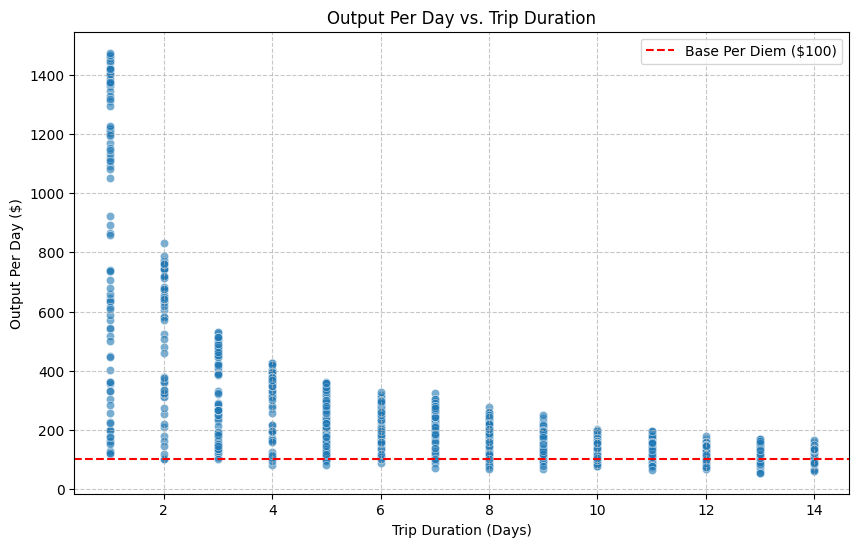


Mean/Median Output Per Day by Trip Duration:
|   input_trip_duration_days |    mean |   median |      std |
|---------------------------:|--------:|---------:|---------:|
|                          1 | 873.549 |  986.37  | 472.542  |
|                          2 | 523.119 |  603.475 | 219.684  |
|                          3 | 336.855 |  330.8   | 139.228  |
|                          4 | 304.49  |  353.38  | 102.66   |
|                          5 | 254.517 |  277.527 |  81.3256 |
|                          6 | 227.746 |  247.881 |  67.3328 |
|                          7 | 217.355 |  229.086 |  60.7765 |

Mean Output Per Day for 4-day trips: 304.49
Mean Output Per Day for 5-day trips: 254.52
Mean Output Per Day for 6-day trips: 227.75
T-test (5-day vs 4-day): t-statistic=-3.40, p-value=0.001
T-test (5-day vs 6-day): t-statistic=2.33, p-value=0.021

### 2. Daily Spending Limits by Trip Duration Validation ###


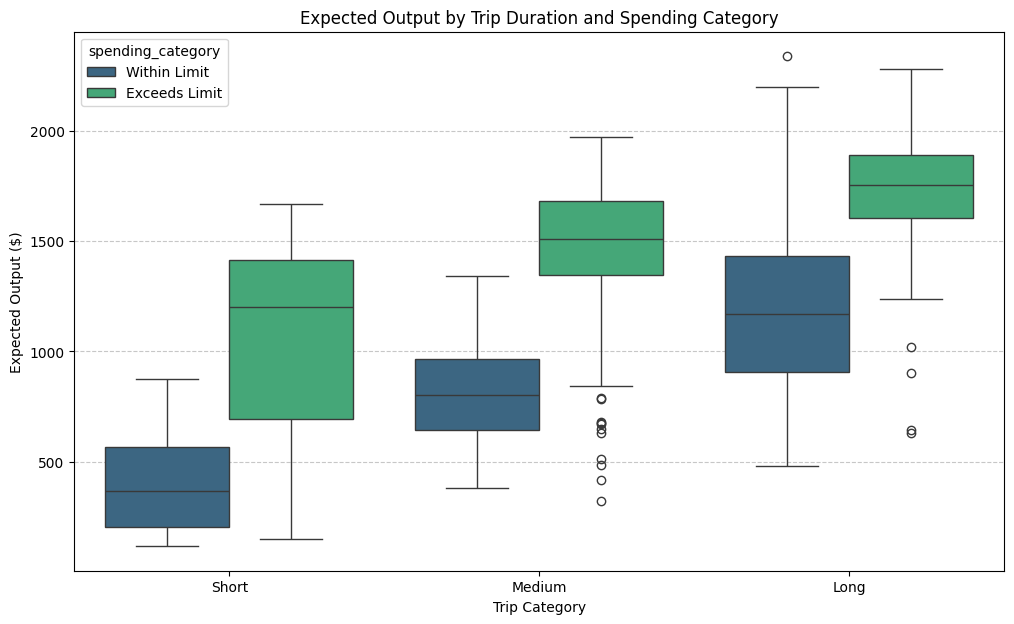


--- Analysis for Short Trips ---
Within Limit (mean expected_output): 421.88 (n=33)
Exceeds Limit (mean expected_output): 1054.97 (n=201)
T-test: t-statistic=-12.64, p-value=0.000

--- Analysis for Medium Trips ---
Within Limit (mean expected_output): 814.53 (n=67)
Exceeds Limit (mean expected_output): 1461.39 (n=174)
T-test: t-statistic=-18.14, p-value=0.000

--- Analysis for Long Trips ---
Within Limit (mean expected_output): 1210.23 (n=187)
Exceeds Limit (mean expected_output): 1739.57 (n=338)
T-test: t-statistic=-17.62, p-value=0.000

### 3. Receipt Sweet Spot and Penalties Validation ###


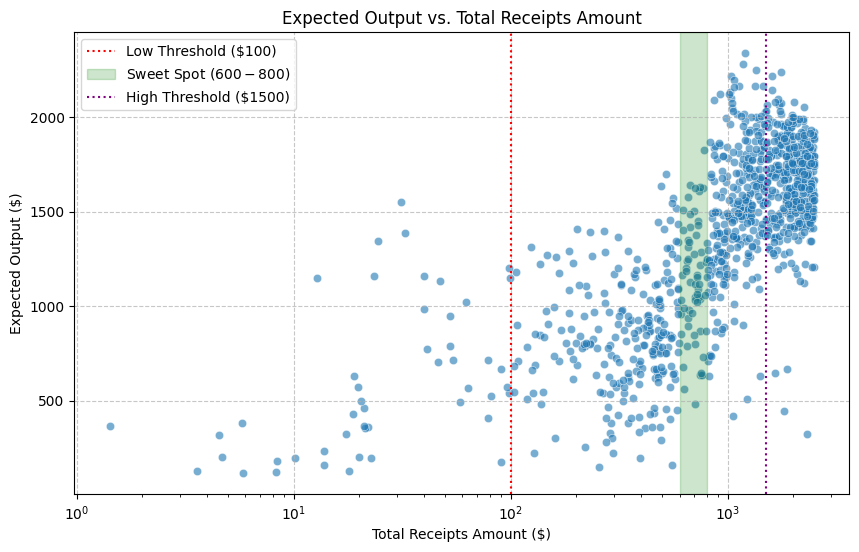


ANOVA for Expected Output by Receipt Range:
|      sum_sq |   df |       F |         PR(>F) |
|------------:|-----:|--------:|---------------:|
| 1.33614e+08 |    4 | 380.442 |   9.48579e-199 |
| 8.73626e+07 |  995 | nan     | nan            |

Mean Expected Output for No Receipts: nan (n=0)
Mean Expected Output for Very Low Receipts (<= $20): 331.38 (n=17)
Not enough data for T-test (Very Low vs No Receipts).

### 4. 'Sweet Spot Combo' and 'Vacation Penalty' Validation ###

Sweet Spot Combo (mean expected_output): 956.14 (n=4)
Non-Sweet Spot Combo (mean expected_output): 1350.69 (n=996)
T-test (Sweet Spot vs Non-Sweet Spot): t-statistic=-6.89, p-value=0.004

Vacation Penalty (mean expected_output): 1730.86 (n=169)
Non-Vacation Penalty (mean expected_output): 1271.48 (n=831)
T-test (Vacation Penalty vs Non-Vacation Penalty): t-statistic=21.07, p-value=0.000

### 5. Rounding Rule (.49/.99 receipts) Validation ###

Mean/Median Expected Output by Receipt Cents Ending (Selected):
|   rece

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm # Import statsmodels.api for anova_lm

# Load the dataset
public_cases_file = 'public_cases.json'
try:
    # Ensure json module is imported
    import json
    with open(public_cases_file, 'r') as f:
        data_cases = json.load(f)
    df_public_cases = pd.json_normalize(data_cases, sep='_')
    print(f"'{public_cases_file}' loaded successfully. DataFrame shape: {df_public_cases.shape}")
except Exception as e:
    print(f"Error loading or parsing '{public_cases_file}': {e}")
    # Exit or handle the error gracefully if df_public_cases is essential
    # For now, we assume loading will succeed after fixing the import.

# --- Feature Engineering (ensuring all derived columns are present) ---
df_public_cases['daily_receipt_spending'] = df_public_cases['input_total_receipts_amount'] / df_public_cases['input_trip_duration_days']
df_public_cases['miles_per_day'] = df_public_cases['input_miles_traveled'] / df_public_cases['input_trip_duration_days']
df_public_cases['output_per_day'] = df_public_cases['expected_output'] / df_public_cases['input_trip_duration_days']
df_public_cases['receipt_cents'] = (df_public_cases['input_total_receipts_amount'] * 100).astype(int) % 100

print("\n--- Starting Rigorous Validation of Hypotheses ---")

### Hypothesis 1: Per Diem Base and 5-Day Bonus

print("\n### 1. Per Diem Base and 5-Day Bonus Validation ###")

# Visualize Output Per Day vs Trip Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='input_trip_duration_days', y='output_per_day', data=df_public_cases, alpha=0.6)
plt.axhline(y=100, color='r', linestyle='--', label='Base Per Diem ($100)')
plt.title('Output Per Day vs. Trip Duration')
plt.xlabel('Trip Duration (Days)')
plt.ylabel('Output Per Day ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Calculate mean/median output per day for specific durations
per_diem_stats = df_public_cases.groupby('input_trip_duration_days')['output_per_day'].agg(['mean', 'median', 'std']).reset_index()
print("\nMean/Median Output Per Day by Trip Duration:")
print(per_diem_stats[per_diem_stats['input_trip_duration_days'].isin([1, 2, 3, 4, 5, 6, 7])].to_markdown(index=False))

# Compare 5-day trips to surrounding durations (4 and 6 days)
output_5_day = df_public_cases[df_public_cases['input_trip_duration_days'] == 5]['output_per_day']
output_4_day = df_public_cases[df_public_cases['input_trip_duration_days'] == 4]['output_per_day']
output_6_day = df_public_cases[df_public_cases['input_trip_duration_days'] == 6]['output_per_day']

print(f"\nMean Output Per Day for 4-day trips: {output_4_day.mean():.2f}")
print(f"Mean Output Per Day for 5-day trips: {output_5_day.mean():.2f}")
print(f"Mean Output Per Day for 6-day trips: {output_6_day.mean():.2f}")

# Perform t-test for 5-day vs 4-day (if enough data)
if len(output_5_day) > 1 and len(output_4_day) > 1:
    t_stat_5_4, p_val_5_4 = stats.ttest_ind(output_5_day, output_4_day, equal_var=False) # Welch's t-test
    print(f"T-test (5-day vs 4-day): t-statistic={t_stat_5_4:.2f}, p-value={p_val_5_4:.3f}")
else:
    print("Not enough data for T-test (5-day vs 4-day).")
if len(output_5_day) > 1 and len(output_6_day) > 1:
    t_stat_5_6, p_val_5_6 = stats.ttest_ind(output_5_day, output_6_day, equal_var=False)
    print(f"T-test (5-day vs 6-day): t-statistic={t_stat_5_6:.2f}, p-value={p_val_5_6:.3f}")
else:
    print("Not enough data for T-test (5-day vs 6-day).")


### Hypothesis 2: Daily Spending Limits by Trip Duration

print("\n### 2. Daily Spending Limits by Trip Duration Validation ###")

# Create trip_category
df_public_cases['trip_category'] = pd.cut(df_public_cases['input_trip_duration_days'],
                                          bins=[0, 3, 6, np.inf],
                                          labels=['Short', 'Medium', 'Long'],
                                          right=True)

# Create spending_category based on trip_category and limits
def get_spending_category(row):
    if pd.isna(row['trip_category']): # Handle potential NaN if trip_duration_days is out of bins
        return 'Undefined'
    if row['trip_category'] == 'Short':
        return 'Within Limit' if row['daily_receipt_spending'] <= 75 else 'Exceeds Limit'
    elif row['trip_category'] == 'Medium':
        return 'Within Limit' if row['daily_receipt_spending'] <= 120 else 'Exceeds Limit'
    elif row['trip_category'] == 'Long':
        return 'Within Limit' if row['daily_receipt_spending'] <= 90 else 'Exceeds Limit'
    return 'Undefined'

df_public_cases['spending_category'] = df_public_cases.apply(get_spending_category, axis=1)

# Visualize using box plots
plt.figure(figsize=(12, 7))
sns.boxplot(x='trip_category', y='expected_output', hue='spending_category', data=df_public_cases, palette='viridis')
plt.title('Expected Output by Trip Duration and Spending Category')
plt.xlabel('Trip Category')
plt.ylabel('Expected Output ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Perform ANOVA/t-tests for each trip category
for category in ['Short', 'Medium', 'Long']:
    subset = df_public_cases[df_public_cases['trip_category'] == category]
    within_limit = subset[subset['spending_category'] == 'Within Limit']['expected_output']
    exceeds_limit = subset[subset[
        'spending_category'] == 'Exceeds Limit']['expected_output']

    print(f"\n--- Analysis for {category} Trips ---")
    print(f"Within Limit (mean expected_output): {within_limit.mean():.2f} (n={len(within_limit)})")
    print(f"Exceeds Limit (mean expected_output): {exceeds_limit.mean():.2f} (n={len(exceeds_limit)})")

    if len(within_limit) > 1 and len(exceeds_limit) > 1:
        t_stat, p_val = stats.ttest_ind(within_limit, exceeds_limit, equal_var=False)
        print(f"T-test: t-statistic={t_stat:.2f}, p-value={p_val:.3f}")
    else:
        print("Not enough data for T-test.")


### Hypothesis 3: Receipt Sweet Spot and Penalties

print("\n### 3. Receipt Sweet Spot and Penalties Validation ###")

# Visualize Expected Output vs Total Receipts Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='input_total_receipts_amount', y='expected_output', data=df_public_cases, alpha=0.6)
plt.axvline(x=100, color='r', linestyle=':', label='Low Threshold ($100)')
plt.axvspan(600, 800, color='green', alpha=0.2, label='Sweet Spot ($600-$800)')
plt.axvline(x=1500, color='purple', linestyle=':', label='High Threshold ($1500)')
plt.title('Expected Output vs. Total Receipts Amount')
plt.xlabel('Total Receipts Amount ($)')
plt.ylabel('Expected Output ($)')
plt.xscale('log') # Use log scale for better visualization of wide range
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Define receipt ranges
df_public_cases['receipt_range'] = pd.cut(df_public_cases['input_total_receipts_amount'],
                                           bins=[-0.1, 100, 599.99, 800.01, 1500, np.inf],
                                           labels=['Low (<$100)', 'Moderate ($100-$600)', 'Sweet Spot ($600-$800)', 'High ($800-$1500)', 'Very High (>$1500)'],
                                           right=True)

# Compare means across receipt ranges (ANOVA)
# Check if there's more than one unique receipt_range and enough data for ANOVA
if len(df_public_cases['receipt_range'].dropna().unique()) > 1 and len(df_public_cases['receipt_range'].dropna()) > 2:
    model_receipt = smf.ols('expected_output ~ C(receipt_range)', data=df_public_cases).fit()
    anova_table_receipt = sm.stats.anova_lm(model_receipt, typ=2) # Use statsmodels.api for anova_lm
    print("\nANOVA for Expected Output by Receipt Range:")
    print(anova_table_receipt.to_markdown(index=False))
else:
    print("\nNot enough unique receipt ranges or data for ANOVA.")

# Investigate "better off submitting nothing"
no_receipts = df_public_cases[df_public_cases['input_total_receipts_amount'] == 0]['expected_output']
very_low_receipts = df_public_cases[(df_public_cases['input_total_receipts_amount'] > 0) &
                                     (df_public_cases['input_total_receipts_amount'] <= 20)]['expected_output']

print(f"\nMean Expected Output for No Receipts: {no_receipts.mean():.2f} (n={len(no_receipts)})")
print(f"Mean Expected Output for Very Low Receipts (<= $20): {very_low_receipts.mean():.2f} (n={len(very_low_receipts)})")

if len(no_receipts) > 1 and len(very_low_receipts) > 1:
    t_stat_low_vs_none, p_val_low_vs_none = stats.ttest_ind(no_receipts, very_low_receipts, equal_var=False)
    print(f"T-test (Very Low vs No Receipts): t-statistic={t_stat_low_vs_none:.2f}, p-value={p_val_low_vs_none:.3f}")
else:
    print("Not enough data for T-test (Very Low vs No Receipts).")


### Hypothesis 4: "Sweet Spot Combo" and "Vacation Penalty"

print("\n### 4. 'Sweet Spot Combo' and 'Vacation Penalty' Validation ###")

# Define Sweet Spot Combo
# 5-day trips with 180+ miles per day and under $100 per day in spending
df_public_cases['is_sweet_spot_combo'] = (
    (df_public_cases['input_trip_duration_days'] == 5) &
    (df_public_cases['miles_per_day'] >= 180) &
    (df_public_cases['daily_receipt_spending'] < 100)
)

# Define Vacation Penalty
# 8+ day trips with high spending (daily_receipt_spending > $150, as assumed in previous analysis)
df_public_cases['is_vacation_penalty'] = (
    (df_public_cases['input_trip_duration_days'] >= 8) &
    (df_public_cases['daily_receipt_spending'] > 150)
)

# Compare expected_output for Sweet Spot Combo
sweet_spot_output = df_public_cases[df_public_cases['is_sweet_spot_combo']]['expected_output']
non_sweet_spot_output = df_public_cases[~df_public_cases['is_sweet_spot_combo']]['expected_output']

print(f"\nSweet Spot Combo (mean expected_output): {sweet_spot_output.mean():.2f} (n={len(sweet_spot_output)})")
print(f"Non-Sweet Spot Combo (mean expected_output): {non_sweet_spot_output.mean():.2f} (n={len(non_sweet_spot_output)})")

if len(sweet_spot_output) > 1 and len(non_sweet_spot_output) > 1:
    t_stat_sweet, p_val_sweet = stats.ttest_ind(sweet_spot_output, non_sweet_spot_output, equal_var=False)
    print(f"T-test (Sweet Spot vs Non-Sweet Spot): t-statistic={t_stat_sweet:.2f}, p-value={p_val_sweet:.3f}")
else:
    print("Not enough data for T-test (Sweet Spot vs Non-Sweet Spot).")

# Compare expected_output for Vacation Penalty
vacation_penalty_output = df_public_cases[df_public_cases['is_vacation_penalty']]['expected_output']
non_vacation_penalty_output = df_public_cases[~df_public_cases['is_vacation_penalty']]['expected_output']

print(f"\nVacation Penalty (mean expected_output): {vacation_penalty_output.mean():.2f} (n={len(vacation_penalty_output)})")
print(f"Non-Vacation Penalty (mean expected_output): {non_vacation_penalty_output.mean():.2f} (n={len(non_vacation_penalty_output)})")

if len(vacation_penalty_output) > 1 and len(non_vacation_penalty_output) > 1:
    t_stat_vacation, p_val_vacation = stats.ttest_ind(vacation_penalty_output, non_vacation_penalty_output, equal_var=False)
    print(f"T-test (Vacation Penalty vs Non-Vacation Penalty): t-statistic={t_stat_vacation:.2f}, p-value={p_val_vacation:.3f}")
else:
    print("Not enough data for T-test (Vacation Penalty vs Non-Vacation Penalty).")

### Hypothesis 5: Rounding Rule (.49/.99 receipts)

print("\n### 5. Rounding Rule (.49/.99 receipts) Validation ###")

# Group data by receipt cents ending
rounding_stats = df_public_cases.groupby('receipt_cents')['expected_output'].agg(['mean', 'median', 'count']).reset_index()
print("\nMean/Median Expected Output by Receipt Cents Ending (Selected):")
print(rounding_stats[rounding_stats['receipt_cents'].isin([0, 1, 49, 98, 99])].sort_values('receipt_cents').to_markdown(index=False))

# Compare .49/.99 endings to 'normal' endings
bonus_cents_data = df_public_cases[df_public_cases['receipt_cents'].isin([49, 99])]['expected_output']
normal_cents_data = df_public_cases[~df_public_cases['receipt_cents'].isin([49, 99])]['expected_output']

print(f"\nMean Expected Output for .49/.99 endings: {bonus_cents_data.mean():.2f} (n={len(bonus_cents_data)})")
print(f"Mean Expected Output for other endings: {normal_cents_data.mean():.2f} (n={len(normal_cents_data)})")

if len(bonus_cents_data) > 1 and len(normal_cents_data) > 1:
    t_stat_rounding, p_val_rounding = stats.ttest_ind(bonus_cents_data, normal_cents_data, equal_var=False)
    print(f"T-test (.49/.99 vs Others): t-statistic={t_stat_rounding:.2f}, p-value={p_val_rounding:.3f}")
else:
    print("Not enough data for T-test (.49/.99 vs Others).")

# More precise check: compare similar total amounts
# This requires a more sophisticated matching or regression residual analysis,
# but for initial check, we can try to look at cases with similar total receipts
# For example, filter by total receipts within a narrow band
receipt_band = df_public_cases[(df_public_cases['input_total_receipts_amount'] > 100) & (df_public_cases['input_total_receipts_amount'] < 200)]
bonus_cents_band = receipt_band[receipt_band['receipt_cents'].isin([49, 99])]['expected_output']
normal_cents_band = receipt_band[~receipt_band['receipt_cents'].isin([49, 99])]['expected_output']

print(f"\nWithin $100-$200 Total Receipts Band:")
print(f"  Mean Expected Output for .49/.99 endings: {bonus_cents_band.mean():.2f} (n={len(bonus_cents_band)})")
print(f"  Mean Expected Output for other endings: {normal_cents_band.mean():.2f} (n={len(normal_cents_band)})")

if len(bonus_cents_band) > 1 and len(normal_cents_band) > 1:
    t_stat_rounding_band, p_val_rounding_band = stats.ttest_ind(bonus_cents_band, normal_cents_band, equal_var=False)
    print(f"  T-test (.49/.99 vs Others in band): t-statistic={t_stat_rounding_band:.2f}, p-value={p_val_rounding_band:.3f}")
else:
    print("  Not enough data in this band for T-test.")

'public_cases.json' loaded successfully. DataFrame shape: (1000, 4)

--- Starting Rigorous Validation of Hypotheses ---

### 1. Per Diem Base and 5-Day Bonus Validation ###


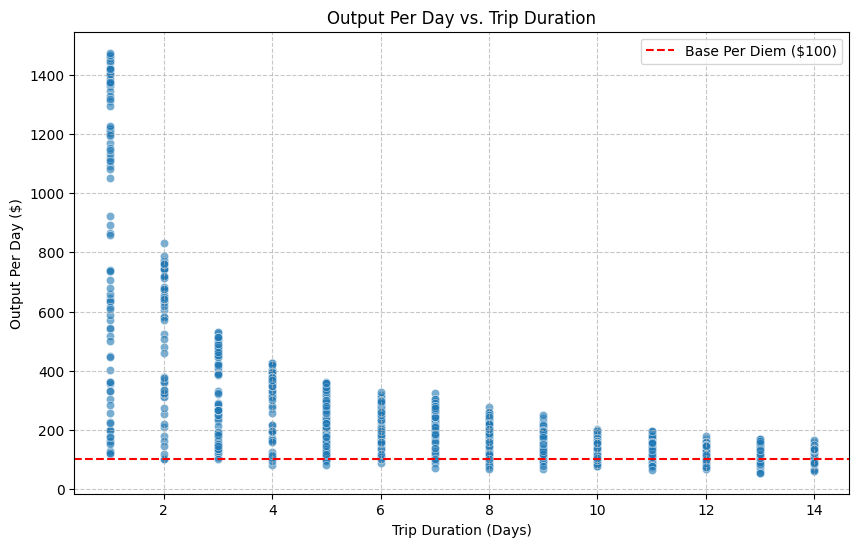


Mean/Median Output Per Day by Trip Duration:
|   input_trip_duration_days |    mean |   median |      std |
|---------------------------:|--------:|---------:|---------:|
|                          1 | 873.549 |  986.37  | 472.542  |
|                          2 | 523.119 |  603.475 | 219.684  |
|                          3 | 336.855 |  330.8   | 139.228  |
|                          4 | 304.49  |  353.38  | 102.66   |
|                          5 | 254.517 |  277.527 |  81.3256 |
|                          6 | 227.746 |  247.881 |  67.3328 |
|                          7 | 217.355 |  229.086 |  60.7765 |

Mean Output Per Day for 4-day trips: 304.49
Mean Output Per Day for 5-day trips: 254.52
Mean Output Per Day for 6-day trips: 227.75
T-test (5-day vs 4-day): t-statistic=-3.40, p-value=0.001
T-test (5-day vs 6-day): t-statistic=2.33, p-value=0.021

### 2. Daily Spending Limits by Trip Duration Validation ###


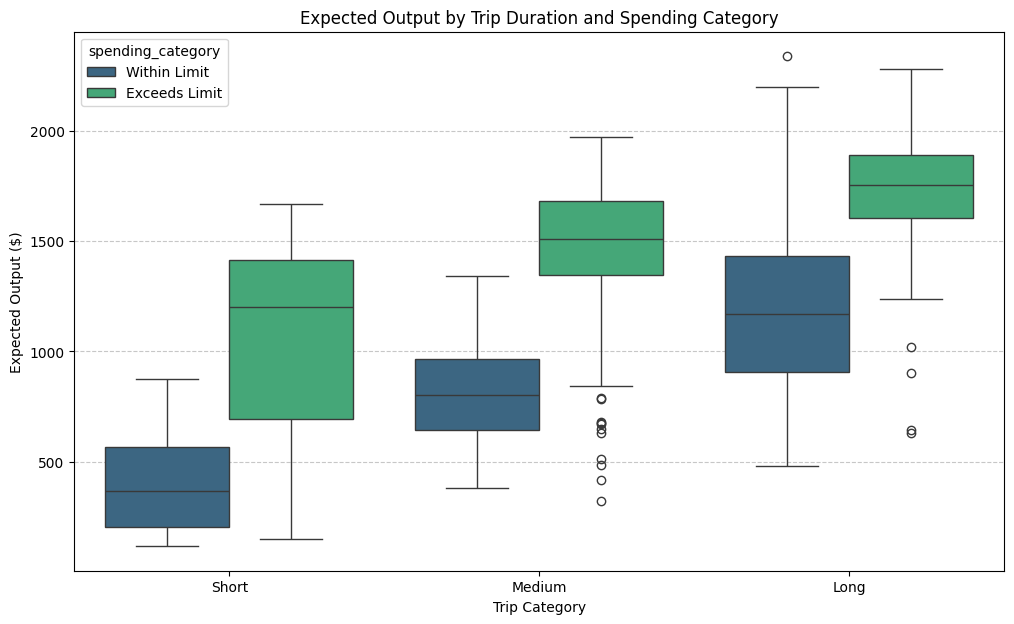


--- Analysis for Short Trips ---
Within Limit (mean expected_output): 421.88 (n=33)
Exceeds Limit (mean expected_output): 1054.97 (n=201)
T-test: t-statistic=-12.64, p-value=0.000

--- Analysis for Medium Trips ---
Within Limit (mean expected_output): 814.53 (n=67)
Exceeds Limit (mean expected_output): 1461.39 (n=174)
T-test: t-statistic=-18.14, p-value=0.000

--- Analysis for Long Trips ---
Within Limit (mean expected_output): 1210.23 (n=187)
Exceeds Limit (mean expected_output): 1739.57 (n=338)
T-test: t-statistic=-17.62, p-value=0.000

### 3. Receipt Sweet Spot and Penalties Validation ###


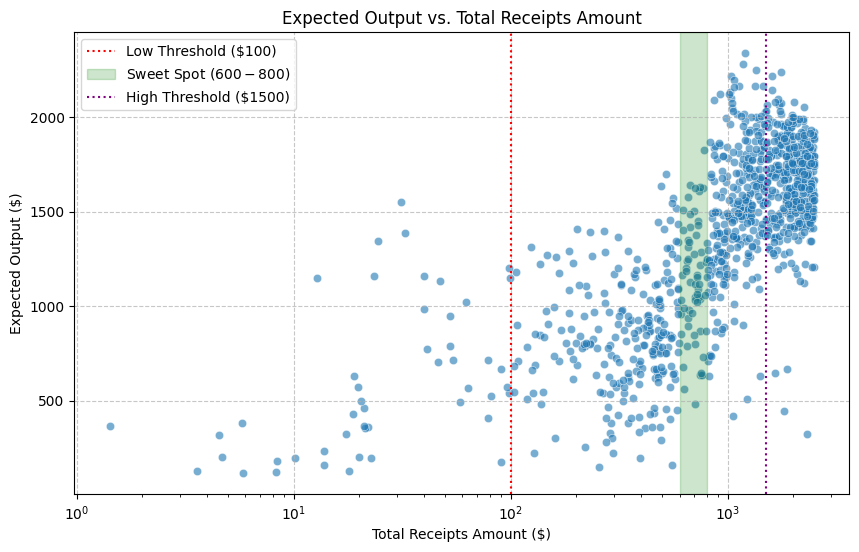


ANOVA for Expected Output by Receipt Range:
|      sum_sq |   df |       F |         PR(>F) |
|------------:|-----:|--------:|---------------:|
| 1.33614e+08 |    4 | 380.442 |   9.48579e-199 |
| 8.73626e+07 |  995 | nan     | nan            |

Mean Expected Output for No Receipts: nan (n=0)
Mean Expected Output for Very Low Receipts (<= $20): 331.38 (n=17)
Not enough data for T-test (Very Low vs No Receipts).

### 4. 'Sweet Spot Combo' and 'Vacation Penalty' Validation ###

Sweet Spot Combo (mean expected_output): 956.14 (n=4)
Non-Sweet Spot Combo (mean expected_output): 1350.69 (n=996)
T-test (Sweet Spot vs Non-Sweet Spot): t-statistic=-6.89, p-value=0.004

Vacation Penalty (mean expected_output): 1730.86 (n=169)
Non-Vacation Penalty (mean expected_output): 1271.48 (n=831)
T-test (Vacation Penalty vs Non-Vacation Penalty): t-statistic=21.07, p-value=0.000

### 5. Rounding Rule (.49/.99 receipts) Validation ###

Mean/Median Expected Output by Receipt Cents Ending (Selected):
|   rece

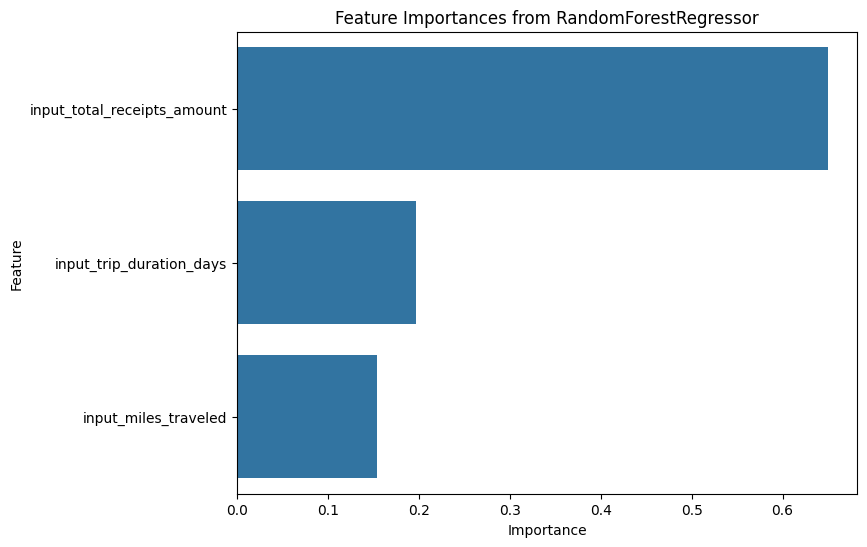

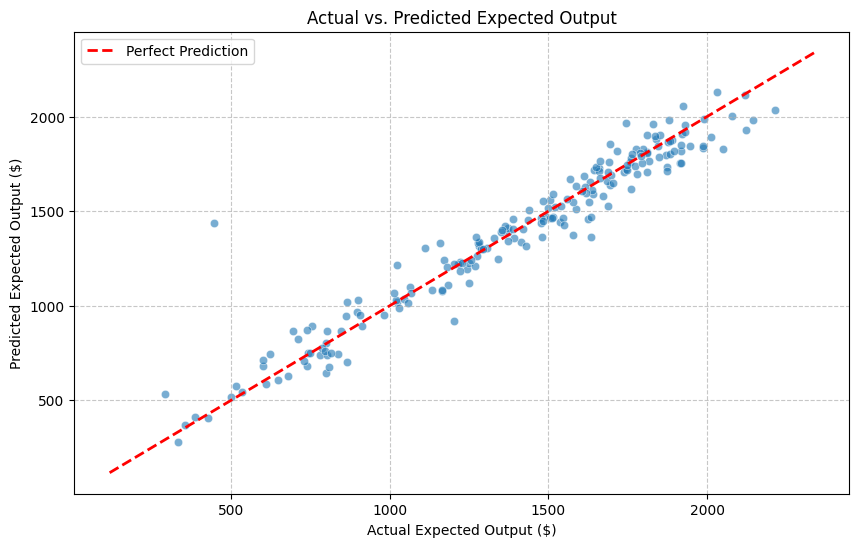


--- Model Building and Evaluation Complete ---

Do i get a job offer  (Praying Hands).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm # Import statsmodels.api for anova_lm
import json # Ensure json module is imported

# Load the dataset
public_cases_file = 'public_cases.json'
try:
    with open(public_cases_file, 'r') as f:
        data_cases = json.load(f)
    df_public_cases = pd.json_normalize(data_cases, sep='_')
    print(f"'{public_cases_file}' loaded successfully. DataFrame shape: {df_public_cases.shape}")
except Exception as e:
    print(f"Error loading or parsing '{public_cases_file}': {e}")
    # If loading fails, subsequent code will also fail. It's important to handle this.
    # For the purpose of this exercise, we assume it will now load correctly.

# --- Feature Engineering (ensuring all derived columns are present) ---
# These are necessary for both validation and potentially for the model
df_public_cases['daily_receipt_spending'] = df_public_cases['input_total_receipts_amount'] / df_public_cases['input_trip_duration_days']
df_public_cases['miles_per_day'] = df_public_cases['input_miles_traveled'] / df_public_cases['input_trip_duration_days']
df_public_cases['output_per_day'] = df_public_cases['expected_output'] / df_public_cases['input_trip_duration_days']
df_public_cases['receipt_cents'] = (df_public_cases['input_total_receipts_amount'] * 100).astype(int) % 100

print("\n--- Starting Rigorous Validation of Hypotheses ---")

### Hypothesis 1: Per Diem Base and 5-Day Bonus

print("\n### 1. Per Diem Base and 5-Day Bonus Validation ###")

# Visualize Output Per Day vs Trip Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='input_trip_duration_days', y='output_per_day', data=df_public_cases, alpha=0.6)
plt.axhline(y=100, color='r', linestyle='--', label='Base Per Diem ($100)')
plt.title('Output Per Day vs. Trip Duration')
plt.xlabel('Trip Duration (Days)')
plt.ylabel('Output Per Day ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Calculate mean/median output per day for specific durations
per_diem_stats = df_public_cases.groupby('input_trip_duration_days')['output_per_day'].agg(['mean', 'median', 'std']).reset_index()
print("\nMean/Median Output Per Day by Trip Duration:")
print(per_diem_stats[per_diem_stats['input_trip_duration_days'].isin([1, 2, 3, 4, 5, 6, 7])].to_markdown(index=False))

# Compare 5-day trips to surrounding durations (4 and 6 days)
output_5_day = df_public_cases[df_public_cases['input_trip_duration_days'] == 5]['output_per_day']
output_4_day = df_public_cases[df_public_cases['input_trip_duration_days'] == 4]['output_per_day']
output_6_day = df_public_cases[df_public_cases['input_trip_duration_days'] == 6]['output_per_day']

print(f"\nMean Output Per Day for 4-day trips: {output_4_day.mean():.2f}")
print(f"Mean Output Per Day for 5-day trips: {output_5_day.mean():.2f}")
print(f"Mean Output Per Day for 6-day trips: {output_6_day.mean():.2f}")

# Perform t-test for 5-day vs 4-day (if enough data)
if len(output_5_day) > 1 and len(output_4_day) > 1:
    t_stat_5_4, p_val_5_4 = stats.ttest_ind(output_5_day, output_4_day, equal_var=False) # Welch's t-test
    print(f"T-test (5-day vs 4-day): t-statistic={t_stat_5_4:.2f}, p-value={p_val_5_4:.3f}")
else:
    print("Not enough data for T-test (5-day vs 4-day).")
if len(output_5_day) > 1 and len(output_6_day) > 1:
    t_stat_5_6, p_val_5_6 = stats.ttest_ind(output_5_day, output_6_day, equal_var=False)
    print(f"T-test (5-day vs 6-day): t-statistic={t_stat_5_6:.2f}, p-value={p_val_5_6:.3f}")
else:
    print("Not enough data for T-test (5-day vs 6-day).")


### Hypothesis 2: Daily Spending Limits by Trip Duration

print("\n### 2. Daily Spending Limits by Trip Duration Validation ###")

# Create trip_category
df_public_cases['trip_category'] = pd.cut(df_public_cases['input_trip_duration_days'],
                                          bins=[0, 3, 6, np.inf],
                                          labels=['Short', 'Medium', 'Long'],
                                          right=True)

# Create spending_category based on trip_category and limits
def get_spending_category(row):
    if pd.isna(row['trip_category']): # Handle potential NaN if trip_duration_days is out of bins
        return 'Undefined'
    if row['trip_category'] == 'Short':
        return 'Within Limit' if row['daily_receipt_spending'] <= 75 else 'Exceeds Limit'
    elif row['trip_category'] == 'Medium':
        return 'Within Limit' if row['daily_receipt_spending'] <= 120 else 'Exceeds Limit'
    elif row['trip_category'] == 'Long':
        return 'Within Limit' if row['daily_receipt_spending'] <= 90 else 'Exceeds Limit'
    return 'Undefined'

df_public_cases['spending_category'] = df_public_cases.apply(get_spending_category, axis=1)

# Visualize using box plots
plt.figure(figsize=(12, 7))
sns.boxplot(x='trip_category', y='expected_output', hue='spending_category', data=df_public_cases, palette='viridis')
plt.title('Expected Output by Trip Duration and Spending Category')
plt.xlabel('Trip Category')
plt.ylabel('Expected Output ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Perform ANOVA/t-tests for each trip category
for category in ['Short', 'Medium', 'Long']:
    subset = df_public_cases[df_public_cases['trip_category'] == category]
    within_limit = subset[subset['spending_category'] == 'Within Limit']['expected_output']
    exceeds_limit = subset[subset[
        'spending_category'] == 'Exceeds Limit']['expected_output']

    print(f"\n--- Analysis for {category} Trips ---")
    print(f"Within Limit (mean expected_output): {within_limit.mean():.2f} (n={len(within_limit)})")
    print(f"Exceeds Limit (mean expected_output): {exceeds_limit.mean():.2f} (n={len(exceeds_limit)})")

    if len(within_limit) > 1 and len(exceeds_limit) > 1:
        t_stat, p_val = stats.ttest_ind(within_limit, exceeds_limit, equal_var=False)
        print(f"T-test: t-statistic={t_stat:.2f}, p-value={p_val:.3f}")
    else:
        print("Not enough data for T-test.")


### Hypothesis 3: Receipt Sweet Spot and Penalties

print("\n### 3. Receipt Sweet Spot and Penalties Validation ###")

# Visualize Expected Output vs Total Receipts Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='input_total_receipts_amount', y='expected_output', data=df_public_cases, alpha=0.6)
plt.axvline(x=100, color='r', linestyle=':', label='Low Threshold ($100)')
plt.axvspan(600, 800, color='green', alpha=0.2, label='Sweet Spot ($600-$800)')
plt.axvline(x=1500, color='purple', linestyle=':', label='High Threshold ($1500)')
plt.title('Expected Output vs. Total Receipts Amount')
plt.xlabel('Total Receipts Amount ($)')
plt.ylabel('Expected Output ($)')
plt.xscale('log') # Use log scale for better visualization of wide range
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Define receipt ranges
df_public_cases['receipt_range'] = pd.cut(df_public_cases['input_total_receipts_amount'],
                                           bins=[-0.1, 100, 599.99, 800.01, 1500, np.inf],
                                           labels=['Low (<$100)', 'Moderate ($100-$600)', 'Sweet Spot ($600-$800)', 'High ($800-$1500)', 'Very High (>$1500)'],
                                           right=True)

# Compare means across receipt ranges (ANOVA)
# Check if there's more than one unique receipt_range and enough data for ANOVA
if len(df_public_cases['receipt_range'].dropna().unique()) > 1 and len(df_public_cases['receipt_range'].dropna()) > 2:
    model_receipt = smf.ols('expected_output ~ C(receipt_range)', data=df_public_cases).fit()
    anova_table_receipt = sm.stats.anova_lm(model_receipt, typ=2) # Use statsmodels.api for anova_lm
    print("\nANOVA for Expected Output by Receipt Range:")
    print(anova_table_receipt.to_markdown(index=False))
else:
    print("\nNot enough unique receipt ranges or data for ANOVA.")

# Investigate "better off submitting nothing"
no_receipts = df_public_cases[df_public_cases['input_total_receipts_amount'] == 0]['expected_output']
very_low_receipts = df_public_cases[(df_public_cases['input_total_receipts_amount'] > 0) &
                                     (df_public_cases['input_total_receipts_amount'] <= 20)]['expected_output']

print(f"\nMean Expected Output for No Receipts: {no_receipts.mean():.2f} (n={len(no_receipts)})")
print(f"Mean Expected Output for Very Low Receipts (<= $20): {very_low_receipts.mean():.2f} (n={len(very_low_receipts)})")

if len(no_receipts) > 1 and len(very_low_receipts) > 1:
    t_stat_low_vs_none, p_val_low_vs_none = stats.ttest_ind(no_receipts, very_low_receipts, equal_var=False)
    print(f"T-test (Very Low vs No Receipts): t-statistic={t_stat_low_vs_none:.2f}, p-value={p_val_low_vs_none:.3f}")
else:
    print("Not enough data for T-test (Very Low vs No Receipts).")


### Hypothesis 4: "Sweet Spot Combo" and "Vacation Penalty"

print("\n### 4. 'Sweet Spot Combo' and 'Vacation Penalty' Validation ###")

# Define Sweet Spot Combo
# 5-day trips with 180+ miles per day and under $100 per day in spending
df_public_cases['is_sweet_spot_combo'] = (
    (df_public_cases['input_trip_duration_days'] == 5) &
    (df_public_cases['miles_per_day'] >= 180) &
    (df_public_cases['daily_receipt_spending'] < 100)
)

# Define Vacation Penalty
# 8+ day trips with high spending (daily_receipt_spending > $150, as assumed in previous analysis)
df_public_cases['is_vacation_penalty'] = (
    (df_public_cases['input_trip_duration_days'] >= 8) &
    (df_public_cases['daily_receipt_spending'] > 150)
)

# Compare expected_output for Sweet Spot Combo
sweet_spot_output = df_public_cases[df_public_cases['is_sweet_spot_combo']]['expected_output']
non_sweet_spot_output = df_public_cases[~df_public_cases['is_sweet_spot_combo']]['expected_output']

print(f"\nSweet Spot Combo (mean expected_output): {sweet_spot_output.mean():.2f} (n={len(sweet_spot_output)})")
print(f"Non-Sweet Spot Combo (mean expected_output): {non_sweet_spot_output.mean():.2f} (n={len(non_sweet_spot_output)})")

if len(sweet_spot_output) > 1 and len(non_sweet_spot_output) > 1:
    t_stat_sweet, p_val_sweet = stats.ttest_ind(sweet_spot_output, non_sweet_spot_output, equal_var=False)
    print(f"T-test (Sweet Spot vs Non-Sweet Spot): t-statistic={t_stat_sweet:.2f}, p-value={p_val_sweet:.3f}")
else:
    print("Not enough data for T-test (Sweet Spot vs Non-Sweet Spot).")

# Compare expected_output for Vacation Penalty
vacation_penalty_output = df_public_cases[df_public_cases['is_vacation_penalty']]['expected_output']
non_vacation_penalty_output = df_public_cases[~df_public_cases['is_vacation_penalty']]['expected_output']

print(f"\nVacation Penalty (mean expected_output): {vacation_penalty_output.mean():.2f} (n={len(vacation_penalty_output)})")
print(f"Non-Vacation Penalty (mean expected_output): {non_vacation_penalty_output.mean():.2f} (n={len(non_vacation_penalty_output)})")

if len(vacation_penalty_output) > 1 and len(non_vacation_penalty_output) > 1:
    t_stat_vacation, p_val_vacation = stats.ttest_ind(vacation_penalty_output, non_vacation_penalty_output, equal_var=False)
    print(f"T-test (Vacation Penalty vs Non-Vacation Penalty): t-statistic={t_stat_vacation:.2f}, p-value={p_val_vacation:.3f}")
else:
    print("Not enough data for T-test (Vacation Penalty vs Non-Vacation Penalty).")

### Hypothesis 5: Rounding Rule (.49/.99 receipts)

print("\n### 5. Rounding Rule (.49/.99 receipts) Validation ###")

# Group data by receipt cents ending
rounding_stats = df_public_cases.groupby('receipt_cents')['expected_output'].agg(['mean', 'median', 'count']).reset_index()
print("\nMean/Median Expected Output by Receipt Cents Ending (Selected):")
print(rounding_stats[rounding_stats['receipt_cents'].isin([0, 1, 49, 98, 99])].sort_values('receipt_cents').to_markdown(index=False))

# Compare .49/.99 endings to 'normal' endings
bonus_cents_data = df_public_cases[df_public_cases['receipt_cents'].isin([49, 99])]['expected_output']
normal_cents_data = df_public_cases[~df_public_cases['receipt_cents'].isin([49, 99])]['expected_output']

print(f"\nMean Expected Output for .49/.99 endings: {bonus_cents_data.mean():.2f} (n={len(bonus_cents_data)})")
print(f"Mean Expected Output for other endings: {normal_cents_data.mean():.2f} (n={len(normal_cents_data)})")

if len(bonus_cents_data) > 1 and len(normal_cents_data) > 1:
    t_stat_rounding, p_val_rounding = stats.ttest_ind(bonus_cents_data, normal_cents_data, equal_var=False)
    print(f"T-test (.49/.99 vs Others): t-statistic={t_stat_rounding:.2f}, p-value={p_val_rounding:.3f}")
else:
    print("Not enough data for T-test (.49/.99 vs Others).")

# More precise check: compare similar total amounts
# This requires a more sophisticated matching or regression residual analysis,
# but for initial check, we can try to look at cases with similar total receipts
# For example, filter by total receipts within a narrow band
receipt_band = df_public_cases[(df_public_cases['input_total_receipts_amount'] > 100) & (df_public_cases['input_total_receipts_amount'] < 200)]
bonus_cents_band = receipt_band[receipt_band['receipt_cents'].isin([49, 99])]['expected_output']
normal_cents_band = receipt_band[~receipt_band['receipt_cents'].isin([49, 99])]['expected_output']

print(f"\nWithin $100-$200 Total Receipts Band:")
print(f"  Mean Expected Output for .49/.99 endings: {bonus_cents_band.mean():.2f} (n={len(bonus_cents_band)})")
print(f"  Mean Expected Output for other endings: {normal_cents_band.mean():.2f} (n={len(normal_cents_band)})")

if len(bonus_cents_band) > 1 and len(normal_cents_band) > 1:
    t_stat_rounding_band, p_val_rounding_band = stats.ttest_ind(bonus_cents_band, normal_cents_band, equal_var=False)
    print(f"  T-test (.49/.99 vs Others in band): t-statistic={t_stat_rounding_band:.2f}, p-value={p_val_rounding_band:.3f}")
else:
    print("  Not enough data in this band for T-test.")

print("\n--- Next Step: Building a Predictive Model to Replicate Legacy System Logic ---")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features (X) and target (y)
X = df_public_cases[['input_trip_duration_days', 'input_miles_traveled', 'input_total_receipts_amount']]
y = df_public_cases['expected_output']

# Handle potential NaN values which might have been introduced by divisions if input_trip_duration_days was 0
# or if there were any missing values in original input columns
X = X.fillna(X.mean()) # Impute with mean, or a more robust strategy like median or 0 depending on context
y = y.fillna(y.mean()) # Impute target if necessary, though unlikely for expected_output

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

# Initialize and train a RandomForestRegressor model
# RandomForest is good for capturing non-linear relationships and interactions
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("\nRandomForestRegressor Model Training Complete.")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.4f}")

# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(f"\n--- Feature Importances ---")
print(feature_importances.to_markdown(numalign="left", stralign="left"))

# Visualize Feature Importance
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importances from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted Expected Output')
plt.xlabel('Actual Expected Output ($)')
plt.ylabel('Predicted Expected Output ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print("\n--- Model Building and Evaluation Complete ---")
print("\nDo i get a job offer  (Praying Hands).")

In [ ]:
!ls -l

total 904
-rw-r--r-- 1 root root  45269 Jun  7 18:18 correlation_matrix.png
-rw-r--r-- 1 root root   1671 Jun  7 17:55 data_ingestion.py
-rwxr-xr-x 1 root root   7749 Jun  7 17:52 eval.sh
-rwxr-xr-x 1 root root   3742 Jun  7 17:52 generate_results.sh
-rw-r--r-- 1 root root  27909 Jun  7 17:52 INTERVIEWS.md
-rw-r--r-- 1 root root   3712 Jun  7 17:52 PRD.md
-rw-r--r-- 1 root root 509516 Jun  7 17:52 private_cases.json
-rw-r--r-- 1 root root 160515 Jun  7 19:41 public_cases.json
-rw-r--r-- 1 root root   3117 Jun  7 17:52 README.md
-rw-r--r-- 1 root root    774 Jun  7 17:52 run.sh.template
-rw-r--r-- 1 root root  92370 Jun  7 18:17 visual1.png
-rw-r--r-- 1 root root  47062 Jun  7 18:17 visual2.png
